In [ ]:
#!pip install pytorch_accelerated
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 11.8 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from torch import nn

from functools import partial
#from pytorch_accelerated import Trainer, notebook_launcher 
#from pytorch_accelerated.trainer import TrainerPlaceholderValues, DEFAULT_CALLBACKS
#from pytorch_accelerated.callbacks import EarlyStoppingCallback, SaveBestModelCallback, TrainerCallback, StopTrainingError
import torchmetrics
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

In [ ]:
# drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Diploma/book_crossing/"

In [ ]:
book_ratings = pd.read_table(path + 'book_ratings.dat', sep="\t", header=0)
book_ratings['time'] = book_ratings.index
book_ratings

,user_id,book_id,rating,time
0,1,6264,7.0,0
1,1,4350,7.0,1
2,1,6252,5.0,2
3,1,202,9.0,3
4,1,6266,6.0,4
...,...,...,...,...
62651,2945,15719,8.0,62651
62652,2945,11960,6.0,62652
62653,2945,8515,9.0,62653
62654,2945,9417,7.0,62654


In [ ]:
users_info = pd.read_table(path + 'users_info.dat', sep="\t", header=0, index_col=False)
users_info

,user_id,Location,Age
0,1,"minneapolis, minnesota, usa",24
1,2,"san diego, california, usa",20
2,3,"novinger, missouri, usa",16
3,4,"sonoma, california, usa",34
4,5,"berkeley, california, usa",23
...,...,...,...
2941,2942,"east orange, new jersey, usa",56
2942,2943,"san antonio, texas, usa",27
2943,2944,"storm lake, iowa, usa",48
2944,2945,"lake george, new york, usa",34


In [ ]:
items_info = pd.read_table(path + 'items_info.dat', sep="\t", header=0, index_col=False)
items_info

,book_id,ISBN,Book_title,Book_Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
1,2,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
2,3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
3,4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...
4,5,0609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,1999,Three Rivers Press,http://images.amazon.com/images/P/0609804618.0...,http://images.amazon.com/images/P/0609804618.0...,http://images.amazon.com/images/P/0609804618.0...
...,...,...,...,...,...,...,...,...,...
17379,17380,0449209202,Guide to Confident Living,Norman Vincent Peale,1985,Fawcett Books,http://images.amazon.com/images/P/0449209202.0...,http://images.amazon.com/images/P/0449209202.0...,http://images.amazon.com/images/P/0449209202.0...
17380,17381,2209014026,Ludwig Feuerbach,F. Engels,1976,La Dispute,http://images.amazon.com/images/P/2209014026.0...,http://images.amazon.com/images/P/2209014026.0...,http://images.amazon.com/images/P/2209014026.0...
17381,17382,070892722X,To Bring You Joy (Ulverscroft Large Print Series),Essie Summers,1992,Ulverscroft Large Print,http://images.amazon.com/images/P/070892722X.0...,http://images.amazon.com/images/P/070892722X.0...,http://images.amazon.com/images/P/070892722X.0...
17382,17383,1570031843,Like Unto Like: A Novel (Southern Classics Ser...,Katherine Sherwood Bonner McDowell,1997,University of South Carolina Press,http://images.amazon.com/images/P/1570031843.0...,http://images.amazon.com/images/P/1570031843.0...,http://images.amazon.com/images/P/1570031843.0...


In [ ]:
items_info.iloc[list(book_ratings[:32]['book_id'] - 1)]

,book_id,ISBN,Book_title,Book_Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
6263,6264,0553280325,Something Wicked This Way Comes,Ray Bradbury,1983,Bantam,http://images.amazon.com/images/P/0553280325.0...,http://images.amazon.com/images/P/0553280325.0...,http://images.amazon.com/images/P/0553280325.0...
4349,4350,0345441184,The Mists of Avalon,MARION ZIMMER BRADLEY,2000,Del Rey,http://images.amazon.com/images/P/0345441184.0...,http://images.amazon.com/images/P/0345441184.0...,http://images.amazon.com/images/P/0345441184.0...
6251,6252,0553265741,Sacred Sins,Nora Roberts,1990,Bantam Books,http://images.amazon.com/images/P/0553265741.0...,http://images.amazon.com/images/P/0553265741.0...,http://images.amazon.com/images/P/0553265741.0...
201,202,0195086295,What a Wonderful World: A Lifetime of Recordings,Bob Thiele,1995,Oxford University Press,http://images.amazon.com/images/P/0195086295.0...,http://images.amazon.com/images/P/0195086295.0...,http://images.amazon.com/images/P/0195086295.0...
6265,6266,0446363499,A Coral Kiss,Jayne Ann Krentz,1992,Warner Books,http://images.amazon.com/images/P/0446363499.0...,http://images.amazon.com/images/P/0446363499.0...,http://images.amazon.com/images/P/0446363499.0...
4809,4810,037312273X,To Marry McAllister (Bachelor Cousins) (Harle...,Carole Mortimer,2002,Harlequin,http://images.amazon.com/images/P/037312273X.0...,http://images.amazon.com/images/P/037312273X.0...,http://images.amazon.com/images/P/037312273X.0...
6250,6251,0679409033,Love Always Remembers: A Book of Poems,Joan Walsh Anglund,1997,Random House,http://images.amazon.com/images/P/0679409033.0...,http://images.amazon.com/images/P/0679409033.0...,http://images.amazon.com/images/P/0679409033.0...
159,160,0375823468,"The Subtle Knife (His Dark Materials, Book 2)",PHILIP PULLMAN,2002,Knopf Books for Young Readers,http://images.amazon.com/images/P/0375823468.0...,http://images.amazon.com/images/P/0375823468.0...,http://images.amazon.com/images/P/0375823468.0...
160,161,0380973839,Martian Chronicles,Ray Bradbury,1997,William Morrow,http://images.amazon.com/images/P/0380973839.0...,http://images.amazon.com/images/P/0380973839.0...,http://images.amazon.com/images/P/0380973839.0...
630,631,0446677574,Just Here Trying to Save a Few Lives : Tales o...,Pamela Grim,2002,Warner Books,http://images.amazon.com/images/P/0446677574.0...,http://images.amazon.com/images/P/0446677574.0...,http://images.amazon.com/images/P/0446677574.0...


In [ ]:
ratings_df = pd.merge(book_ratings, items_info)[['user_id', 'book_id', 'Book_title', 'time', 'rating']]
ratings_df

,user_id,book_id,Book_title,time,rating
0,1,6264,Something Wicked This Way Comes,0,7.0
1,496,6264,Something Wicked This Way Comes,10090,8.0
2,676,6264,Something Wicked This Way Comes,14043,10.0
3,1842,6264,Something Wicked This Way Comes,39880,10.0
4,1,4350,The Mists of Avalon,1,7.0
...,...,...,...,...,...
62651,2945,16981,"Jessi Ramsey, Pet Sitter (Baby-Sitters Club (P...",62642,7.0
62652,2945,14501,STAY AWAY FROM THE TREEHOUSE (GHOSTS OF FEAR S...,62643,7.0
62653,2945,3490,Bright Eyes (Coulter Family Series),62649,8.0
62654,2945,15719,Arcadia,62651,8.0


In [ ]:
ratings_df["user_id"] = ratings_df["user_id"].astype(str)

In [ ]:
ratings_per_user = ratings_df.groupby('user_id').rating.count()
ratings_per_item = ratings_df.groupby('Book_title').rating.count()

print(f"Total No. of users: {len(ratings_df.user_id.unique())}")
print(f"Total No. of items: {len(ratings_df.Book_title.unique())}")
print("\n")

print(f"Max observed rating: {ratings_df.rating.max()}")
print(f"Min observed rating: {ratings_df.rating.min()}")
print("\n")

print(f"Max no. of user ratings: {ratings_per_user.max()}")
print(f"Min no. of user ratings: {ratings_per_user.min()}")
print(f"Median no. of ratings per user: {ratings_per_user.median()}")
print("\n")

print(f"Max no. of item ratings: {ratings_per_item.max()}")
print(f"Min no. of item ratings: {ratings_per_item.min()}")
print(f"Median no. of ratings per item: {ratings_per_item.median()}")

Total No. of users: 1295
Total No. of items: 14017


Max observed rating: 10.0
Min observed rating: 1.0


Max no. of user ratings: 1092
Min no. of user ratings: 20
Median no. of ratings per user: 33.0


Max no. of item ratings: 160
Min no. of item ratings: 1
Median no. of ratings per item: 3.0


In [ ]:
def get_last_n_ratings_by_user(
    df, n, min_ratings_per_user=1, user_colname="user_id", timestamp_colname="time"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

In [ ]:
get_last_n_ratings_by_user(ratings_df, 1)

,user_id,book_id,Book_title,time,rating
752,1,4156,Phantom,31,8.0
6273,1002,1444,The 21 Lessons of Merlyn: A Study in Druid Mag...,20881,10.0
50256,1003,11898,Circle Works: Transforming Eurocentric Conscio...,21973,9.0
53489,1004,16575,"Peace, Beetle Bailey",22005,10.0
27675,1005,1207,The Big Book of Calm,22055,10.0
...,...,...,...,...,...
10346,99,1962,"A Fever in the Heart : Ann Rule's Crime Files,...",1973,8.0
52186,990,1235,Man's Search For Meaning,20741,9.0
36669,991,5860,Prime Cut,20768,8.0
36355,995,236,El desarrollo de Leonardo da Vinci (BiografÃ­a...,20827,6.0


In [ ]:
def mark_last_n_ratings_as_validation_set(
    df, n, min_ratings=1, user_colname="user_id", timestamp_colname="time"
  ):
    df["is_valid"] = False
    df.loc[
        get_last_n_ratings_by_user(
            df,
            n,
            min_ratings,
            user_colname=user_colname,
            timestamp_colname=timestamp_colname,
        ).index,
        "is_valid",
    ] = True
    return df

In [ ]:
mark_last_n_ratings_as_validation_set(ratings_df, 1)

,user_id,book_id,Book_title,time,rating,is_valid
0,1,6264,Something Wicked This Way Comes,0,7.0,False
1,496,6264,Something Wicked This Way Comes,10090,8.0,False
2,676,6264,Something Wicked This Way Comes,14043,10.0,False
3,1842,6264,Something Wicked This Way Comes,39880,10.0,False
4,1,4350,The Mists of Avalon,1,7.0,False
...,...,...,...,...,...,...
62651,2945,16981,"Jessi Ramsey, Pet Sitter (Baby-Sitters Club (P...",62642,7.0,False
62652,2945,14501,STAY AWAY FROM THE TREEHOUSE (GHOSTS OF FEAR S...,62643,7.0,False
62653,2945,3490,Bright Eyes (Coulter Family Series),62649,8.0,False
62654,2945,15719,Arcadia,62651,8.0,False


In [ ]:
train_df = ratings_df[ratings_df.is_valid==False]
valid_df = ratings_df[ratings_df.is_valid==True]

In [ ]:
len(valid_df)

1295

In [ ]:
median_rating = train_df.rating.median()
median_rating

8.0

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = np.array([median_rating]* len(valid_df))

mae = mean_absolute_error(valid_df.rating, predictions)
mse = mean_squared_error(valid_df.rating, predictions)
rmse = math.sqrt(mse)

print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mae: 1.3845559845559845
mse: 3.3644787644787644
rmse: 1.834251554307305


In [ ]:
user_lookup = {v: i+1 for i, v in enumerate(ratings_df['user_id'].unique())}

In [ ]:
book_lookup = {v: i+1 for i, v in enumerate(ratings_df['Book_title'].unique())}

In [ ]:
class UserItemRatingDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup):
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup
    def __getitem__(self, index):
        row = self.df.iloc[index]
        user_id = self.user_lookup[row.user_id]
        movie_id = self.movie_lookup[row.Book_title]
        
        rating = torch.tensor(row.rating, dtype=torch.float32)
        
        return torch.tensor(user_id), torch.tensor(movie_id), rating
    def __len__(self):
        return len(self.df)

In [ ]:
train_dataset = UserItemRatingDataset(train_df, movie_lookup, user_lookup)
valid_dataset = UserItemRatingDataset(valid_df, movie_lookup, user_lookup)

In [ ]:
class MatrixFactorizationModel(nn.Module):
    def __init__(
        self, n_factors, n_users, n_items, ratings_range=None, use_biases=True
    ):
        super().__init__()
        self.bias = use_biases
        self.y_range = ratings_range
        self.user_embedding = nn.Embedding(n_users+1, n_factors, padding_idx=0)
        self.item_embedding = nn.Embedding(n_items+1, n_factors, padding_idx=0)
        if use_biases:
            self.user_bias = nn.Embedding(n_users+1, 1, padding_idx=0)
            self.item_bias = nn.Embedding(n_items+1, 1, padding_idx=0)
    def forward(self, inputs):
        users, items = inputs
        dot = self.user_embedding(users) * self.item_embedding(items)
        # print(dot)
        result = dot.sum(1)
        if self.bias:
            result = (
                result + self.user_bias(users).squeeze() + self.item_bias(items).squeeze()
            )
        if self.y_range is None:
            return result
        else:
            return (
                torch.sigmoid(result) * (self.y_range[1] - self.y_range[0])
                + self.y_range[0]
            )

# Common PyTorch
Matrix Factorization model development

In [ ]:
def plot_losses():
  # make data
  x = np.arange(1, len(all_train_losses)+1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, all_train_losses, linewidth=2.0, label="Train")
  ax.plot(x, all_valid_losses, linewidth=2.0, label="Valid")
  best = [best_valid_loss for i in range(len(all_train_losses))]
  ax.plot(x, best, 'r--', linewidth=1.25, label=f'{best_valid_loss}')

  # ax.set(xlim=(0, 50), xticks=np.arange(1, 8),
  #        ylim=(0, 8), yticks=np.arange(1, 8))
  plt.grid()
  plt.title("Losses")
  plt.xlabel("Epochs")
  plt.ylabel("Cross-entropy loss")
  ax.legend()
  plt.show()

In [ ]:
def plot_metrics():
  # make data
  x = np.arange(1, len(all_train_metrics)+1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, all_train_metrics, linewidth=2.0, label="Train")
  ax.plot(x, all_val_metrics, linewidth=2.0, label="Valid")
  best = [best_val_metric for i in range(len(all_train_metrics))]
  ax.plot(x, best, 'r--', linewidth=1.25, label=f'{best_val_metric}')

  # ax.set(xlim=(0, 50), xticks=np.arange(1, 8),
  #        ylim=(0, 8), yticks=np.arange(1, 8))
  plt.grid()
  plt.title("Metrics")
  plt.xlabel("Epochs")
  plt.ylabel("MAE")
  ax.legend()
  plt.show()

In [ ]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler = train_sampler, batch_size = 512)

val_sampler = RandomSampler(valid_dataset) # SequentialSampler(val_data)
val_dataloader = DataLoader(valid_dataset, sampler = val_sampler, batch_size = 512)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = MatrixFactorizationModel(
    120, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)

In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    mae_metrics = 0
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        # print(batch)
        batch = [r.to(device) for r in batch]
        # print(batch.device)
        # print("===============================================")
        user_ids, book_ids, target_ratings = batch
        # print(user_ids.device, book_ids.device, target_ratings.device)
        # model.zero_grad()
        pred_ratings = model((user_ids, book_ids))
        loss = loss_func(pred_ratings, target_ratings)
        total_loss += loss.item()
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = pred_ratings.detach().cpu().numpy()
        mae_metrics += mae_func(pred_ratings.detach().cpu(), target_ratings.detach().cpu())
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    mae_metrics /= len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
        
    return avg_loss, mae_metrics, total_preds

def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    mae_metrics = 0

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        user_ids, book_ids, target_ratings = batch
        with torch.no_grad():
            pred_ratings = model((user_ids, book_ids))
            loss = loss_func(pred_ratings, target_ratings)
            total_loss = total_loss + loss.item()
            # mae_metrics += mae_func(pred_rating, taget_rating)
            preds = pred_ratings.detach().cpu().numpy()
            mae_metrics += mae_func(pred_ratings.detach().cpu(), target_ratings.detach().cpu())
            print(mae_metrics)
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    mae_metrics /= len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, mae_metrics, total_preds

# Old experiments

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 50
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 50


100%|██████████| 3/3 [00:00<00:00, 10.56it/s]

tensor(4.1428)
tensor(7.9752)
tensor(11.8890)



Training loss: 24.850
Validation loss: 23.852
Training MAE: 4.062870979309082
Validation MAE: 3.963003158569336

 Epoch2 / 50


100%|██████████| 3/3 [00:00<00:00,  9.59it/s]

tensor(3.8338)
tensor(7.8102)
tensor(11.7140)



Training loss: 18.994
Validation loss: 23.355
Training MAE: 3.3832180500030518
Validation MAE: 3.9046592712402344

 Epoch3 / 50


100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

tensor(4.1065)
tensor(7.8507)
tensor(11.3625)



Training loss: 16.512
Validation loss: 22.485
Training MAE: 3.0978169441223145
Validation MAE: 3.787487030029297

 Epoch4 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.04it/s]

tensor(3.6965)
tensor(7.3365)
tensor(11.1603)


100%|██████████| 3/3 [00:00<00:00,  9.39it/s]



Training loss: 14.943
Validation loss: 21.857
Training MAE: 2.9216933250427246
Validation MAE: 3.720094680786133

 Epoch5 / 50


100%|██████████| 3/3 [00:00<00:00,  9.35it/s]

tensor(3.5996)
tensor(7.1604)
tensor(10.6241)



Training loss: 13.714
Validation loss: 20.179
Training MAE: 2.782632350921631
Validation MAE: 3.541367292404175

 Epoch6 / 50


100%|██████████| 3/3 [00:00<00:00,  9.62it/s]


tensor(3.3768)
tensor(6.9629)
tensor(10.3351)

Training loss: 12.831
Validation loss: 19.312
Training MAE: 2.6828854084014893
Validation MAE: 3.445040464401245

 Epoch7 / 50


100%|██████████| 3/3 [00:00<00:00,  9.88it/s]

tensor(3.4561)
tensor(7.0910)
tensor(10.2585)



Training loss: 12.234
Validation loss: 18.949
Training MAE: 2.615464925765991
Validation MAE: 3.4194862842559814

 Epoch8 / 50


100%|██████████| 3/3 [00:00<00:00,  9.34it/s]


tensor(3.4359)
tensor(6.7153)
tensor(10.3014)

Training loss: 11.740
Validation loss: 19.009
Training MAE: 2.559314489364624
Validation MAE: 3.433788537979126

 Epoch9 / 50


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]

tensor(3.4305)
tensor(6.8429)
tensor(9.9480)



Training loss: 11.387
Validation loss: 18.330
Training MAE: 2.520347833633423
Validation MAE: 3.315999984741211

 Epoch10 / 50


100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


tensor(3.3950)
tensor(6.7528)
tensor(10.2324)

Training loss: 11.078
Validation loss: 19.011
Training MAE: 2.4854557514190674
Validation MAE: 3.4107837677001953

 Epoch11 / 50


100%|██████████| 3/3 [00:00<00:00,  8.95it/s]


tensor(3.3801)
tensor(6.6956)
tensor(10.2008)

Training loss: 10.883
Validation loss: 18.707
Training MAE: 2.463024616241455
Validation MAE: 3.4002676010131836

 Epoch12 / 50


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

tensor(3.2528)
tensor(6.7269)
tensor(9.9393)



Training loss: 10.726
Validation loss: 17.979
Training MAE: 2.445266008377075
Validation MAE: 3.3130877017974854

 Epoch13 / 50


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

tensor(3.3357)
tensor(6.3753)
tensor(9.7893)



Training loss: 10.675
Validation loss: 17.561
Training MAE: 2.439701557159424
Validation MAE: 3.263101577758789

 Epoch14 / 50


100%|██████████| 3/3 [00:00<00:00,  9.83it/s]

tensor(3.2286)
tensor(6.3009)
tensor(9.7213)



Training loss: 10.604
Validation loss: 17.335
Training MAE: 2.4335851669311523
Validation MAE: 3.2404396533966064

 Epoch15 / 50


100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

tensor(3.0132)
tensor(6.1776)
tensor(9.3273)



Training loss: 10.517
Validation loss: 16.270
Training MAE: 2.4231362342834473
Validation MAE: 3.1090869903564453

 Epoch16 / 50


100%|██████████| 3/3 [00:00<00:00, 10.03it/s]

tensor(2.9937)
tensor(6.1584)
tensor(9.1857)



Training loss: 10.425
Validation loss: 15.727
Training MAE: 2.412001371383667
Validation MAE: 3.0618896484375

 Epoch17 / 50


100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

tensor(2.9661)
tensor(5.9613)
tensor(8.9890)



Training loss: 10.413
Validation loss: 15.350
Training MAE: 2.410820960998535
Validation MAE: 2.9963467121124268

 Epoch18 / 50


100%|██████████| 3/3 [00:00<00:00,  9.61it/s]

tensor(2.9133)
tensor(5.8705)
tensor(8.8885)



Training loss: 10.345
Validation loss: 15.048
Training MAE: 2.4028995037078857
Validation MAE: 2.9628307819366455

 Epoch19 / 50


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]

tensor(2.9548)
tensor(5.7853)
tensor(8.5957)



Training loss: 10.363
Validation loss: 14.076
Training MAE: 2.4055564403533936
Validation MAE: 2.865229606628418

 Epoch20 / 50


100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

tensor(2.8898)
tensor(5.7221)
tensor(8.4668)



Training loss: 10.311
Validation loss: 13.788
Training MAE: 2.3996236324310303
Validation MAE: 2.82226300239563

 Epoch21 / 50


100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

tensor(2.7673)
tensor(5.5389)
tensor(8.4943)



Training loss: 10.275
Validation loss: 13.734
Training MAE: 2.395038366317749
Validation MAE: 2.831434965133667

 Epoch22 / 50


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]

tensor(2.7990)
tensor(5.5919)
tensor(8.4525)



Training loss: 10.215
Validation loss: 13.594
Training MAE: 2.3885085582733154
Validation MAE: 2.817490339279175

 Epoch23 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.04it/s]

tensor(2.8815)
tensor(5.6407)
tensor(8.1417)


100%|██████████| 3/3 [00:00<00:00,  9.58it/s]



Training loss: 10.205
Validation loss: 12.836
Training MAE: 2.38731050491333
Validation MAE: 2.7139084339141846

 Epoch24 / 50


100%|██████████| 3/3 [00:00<00:00,  9.25it/s]


tensor(2.6808)
tensor(5.4192)
tensor(8.1375)

Training loss: 10.186
Validation loss: 12.926
Training MAE: 2.3848044872283936
Validation MAE: 2.712514638900757

 Epoch25 / 50


100%|██████████| 3/3 [00:00<00:00,  9.49it/s]

tensor(2.5696)
tensor(5.3743)
tensor(8.0422)



Training loss: 10.197
Validation loss: 12.628
Training MAE: 2.3878350257873535
Validation MAE: 2.680732011795044

 Epoch26 / 50


100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


tensor(2.5290)
tensor(5.0486)
tensor(8.1184)

Training loss: 10.154
Validation loss: 12.845
Training MAE: 2.383038282394409
Validation MAE: 2.7061424255371094

 Epoch27 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.03it/s]

tensor(2.5860)
tensor(5.3589)


100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


tensor(7.9990)

Training loss: 10.111
Validation loss: 12.539
Training MAE: 2.3767764568328857
Validation MAE: 2.666346788406372

 Epoch28 / 50


100%|██████████| 3/3 [00:00<00:00, 10.04it/s]


tensor(2.4651)
tensor(5.2123)
tensor(8.1117)

Training loss: 10.079
Validation loss: 12.689
Training MAE: 2.3737146854400635
Validation MAE: 2.703897476196289

 Epoch29 / 50


100%|██████████| 3/3 [00:00<00:00, 10.16it/s]


tensor(2.5839)
tensor(5.2421)
tensor(8.1451)

Training loss: 10.134
Validation loss: 12.826
Training MAE: 2.3801779747009277
Validation MAE: 2.715043306350708

 Epoch30 / 50


100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


tensor(2.7203)
tensor(5.4841)
tensor(7.9765)

Training loss: 10.180
Validation loss: 12.569
Training MAE: 2.38523006439209
Validation MAE: 2.6588358879089355

 Epoch31 / 50


100%|██████████| 3/3 [00:00<00:00, 10.21it/s]


tensor(2.7627)
tensor(5.4281)
tensor(8.2356)

Training loss: 10.163
Validation loss: 13.213
Training MAE: 2.3831496238708496
Validation MAE: 2.745210647583008

 Epoch32 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.72it/s]

tensor(2.8855)
tensor(5.7402)


100%|██████████| 3/3 [00:00<00:00,  9.21it/s]


tensor(8.2097)

Training loss: 10.151
Validation loss: 13.282
Training MAE: 2.382168769836426
Validation MAE: 2.7365541458129883

 Epoch33 / 50


100%|██████████| 3/3 [00:00<00:00,  9.59it/s]


tensor(2.8924)
tensor(5.5711)
tensor(8.3479)

Training loss: 10.056
Validation loss: 13.661
Training MAE: 2.3712477684020996
Validation MAE: 2.782646417617798

 Epoch34 / 50


100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


tensor(2.7671)
tensor(5.4894)
tensor(8.2593)

Training loss: 10.073
Validation loss: 13.480
Training MAE: 2.3730645179748535
Validation MAE: 2.7531089782714844

 Epoch35 / 50


100%|██████████| 3/3 [00:00<00:00,  9.71it/s]


tensor(2.6364)
tensor(5.3973)
tensor(8.1625)

Training loss: 10.063
Validation loss: 13.073
Training MAE: 2.371480703353882
Validation MAE: 2.720837354660034

 Epoch36 / 50


100%|██████████| 3/3 [00:00<00:00,  9.47it/s]


tensor(2.4933)
tensor(5.3393)
tensor(8.0484)

Training loss: 10.037
Validation loss: 12.854
Training MAE: 2.3695247173309326
Validation MAE: 2.682814598083496

 Epoch37 / 50


100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


tensor(2.6003)
tensor(5.4024)
tensor(8.0549)

Training loss: 10.055
Validation loss: 12.808
Training MAE: 2.37073016166687
Validation MAE: 2.6849639415740967

 Epoch38 / 50


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]


tensor(2.6307)
tensor(5.2684)
tensor(8.0959)

Training loss: 10.103
Validation loss: 12.732
Training MAE: 2.3762638568878174
Validation MAE: 2.6986277103424072

 Epoch39 / 50


100%|██████████| 3/3 [00:00<00:00,  9.79it/s]

tensor(2.7434)
tensor(5.3342)
tensor(7.8798)



Training loss: 10.117
Validation loss: 12.295
Training MAE: 2.3781306743621826
Validation MAE: 2.6265835762023926

 Epoch40 / 50


100%|██████████| 3/3 [00:00<00:00, 10.29it/s]


tensor(2.5551)
tensor(5.2673)
tensor(7.8761)

Training loss: 9.967
Validation loss: 12.372
Training MAE: 2.360119342803955
Validation MAE: 2.625372886657715

 Epoch41 / 50


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

tensor(2.6982)
tensor(5.3305)
tensor(7.8101)



Training loss: 9.953
Validation loss: 12.206
Training MAE: 2.359739065170288
Validation MAE: 2.6033670902252197

 Epoch42 / 50


 33%|███▎      | 1/3 [00:00<00:00,  8.09it/s]

tensor(2.5567)


100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


tensor(5.1150)
tensor(7.7086)

Training loss: 10.031
Validation loss: 11.765
Training MAE: 2.367997169494629
Validation MAE: 2.5695455074310303

 Epoch43 / 50


100%|██████████| 3/3 [00:00<00:00,  9.18it/s]


tensor(2.5181)
tensor(4.9476)
tensor(7.7525)

Training loss: 9.964
Validation loss: 11.925
Training MAE: 2.36124587059021
Validation MAE: 2.5841705799102783

 Epoch44 / 50


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]

tensor(2.5843)
tensor(5.1198)
tensor(7.5855)



Training loss: 9.986
Validation loss: 11.514
Training MAE: 2.363595485687256
Validation MAE: 2.528505802154541

 Epoch45 / 50


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


tensor(2.5321)
tensor(5.1211)
tensor(7.5447)

Training loss: 9.964
Validation loss: 11.520
Training MAE: 2.3612053394317627
Validation MAE: 2.514894723892212

 Epoch46 / 50


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]

tensor(2.6215)
tensor(5.2071)
tensor(7.4927)



Training loss: 9.937
Validation loss: 11.125
Training MAE: 2.3587019443511963
Validation MAE: 2.4975521564483643

 Epoch47 / 50


100%|██████████| 3/3 [00:00<00:00,  9.90it/s]

tensor(2.5673)
tensor(5.1366)
tensor(7.4751)



Training loss: 9.932
Validation loss: 11.098
Training MAE: 2.3572628498077393
Validation MAE: 2.4916911125183105

 Epoch48 / 50


100%|██████████| 3/3 [00:00<00:00, 10.25it/s]

tensor(2.5437)
tensor(4.9571)
tensor(7.4139)



Training loss: 9.937
Validation loss: 10.917
Training MAE: 2.357966899871826
Validation MAE: 2.471306324005127

 Epoch49 / 50


100%|██████████| 3/3 [00:00<00:00,  9.22it/s]


tensor(2.4901)
tensor(4.9878)
tensor(7.5937)

Training loss: 9.848
Validation loss: 11.519
Training MAE: 2.3477938175201416
Validation MAE: 2.531245470046997

 Epoch50 / 50


100%|██████████| 3/3 [00:00<00:00,  9.18it/s]

tensor(2.3677)
tensor(5.0726)
tensor(7.5118)

Training loss: 9.844
Validation loss: 11.165
Training MAE: 2.348214864730835
Validation MAE: 2.5039491653442383


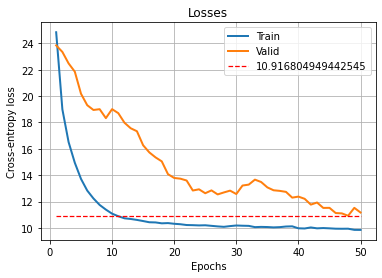

In [ ]:
plot_losses()

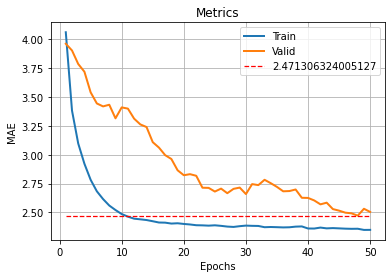

In [ ]:
plot_metrics()

In [ ]:
model = MatrixFactorizationModel(
    80, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 50
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 50


100%|██████████| 3/3 [00:00<00:00, 10.03it/s]

tensor(3.9136)
tensor(7.8373)
tensor(11.5425)



Training loss: 24.001
Validation loss: 22.622
Training MAE: 3.9821901321411133
Validation MAE: 3.847510576248169

 Epoch2 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.13it/s]

tensor(3.6143)
tensor(7.1907)


100%|██████████| 3/3 [00:00<00:00,  9.34it/s]


tensor(10.9797)

Training loss: 17.138
Validation loss: 21.134
Training MAE: 3.1763570308685303
Validation MAE: 3.6599109172821045

 Epoch3 / 50


100%|██████████| 3/3 [00:00<00:00,  9.37it/s]

tensor(3.3513)
tensor(7.1021)
tensor(10.7458)



Training loss: 14.268
Validation loss: 20.570
Training MAE: 2.849322557449341
Validation MAE: 3.5819320678710938

 Epoch4 / 50


100%|██████████| 3/3 [00:00<00:00,  9.73it/s]

tensor(3.5355)
tensor(7.0245)
tensor(10.4101)



Training loss: 12.518
Validation loss: 19.477
Training MAE: 2.650317907333374
Validation MAE: 3.4700472354888916

 Epoch5 / 50


100%|██████████| 3/3 [00:00<00:00,  9.78it/s]

tensor(3.5317)
tensor(6.9650)
tensor(10.3512)



Training loss: 11.443
Validation loss: 19.147
Training MAE: 2.5267879962921143
Validation MAE: 3.4503965377807617

 Epoch6 / 50


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


tensor(3.4263)
tensor(6.8440)
tensor(10.2013)

Training loss: 10.789
Validation loss: 18.950
Training MAE: 2.453636646270752
Validation MAE: 3.400423049926758

 Epoch7 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.55it/s]

tensor(3.2239)
tensor(6.5445)


100%|██████████| 3/3 [00:00<00:00,  9.02it/s]


tensor(9.6977)

Training loss: 10.336
Validation loss: 17.213
Training MAE: 2.4026479721069336
Validation MAE: 3.232569932937622

 Epoch8 / 50


100%|██████████| 3/3 [00:00<00:00, 10.13it/s]

tensor(2.9861)
tensor(6.3334)
tensor(9.4810)



Training loss: 10.005
Validation loss: 16.566
Training MAE: 2.3648312091827393
Validation MAE: 3.1603448390960693

 Epoch9 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.14it/s]

tensor(3.1301)
tensor(6.1763)


100%|██████████| 3/3 [00:00<00:00,  7.26it/s]


tensor(9.1009)

Training loss: 9.729
Validation loss: 15.498
Training MAE: 2.3345606327056885
Validation MAE: 3.033634901046753

 Epoch10 / 50


100%|██████████| 3/3 [00:00<00:00,  8.70it/s]

tensor(3.0414)
tensor(5.9938)
tensor(9.0394)



Training loss: 9.562
Validation loss: 15.377
Training MAE: 2.3152663707733154
Validation MAE: 3.013122320175171

 Epoch11 / 50


100%|██████████| 3/3 [00:00<00:00,  8.88it/s]

tensor(3.0151)
tensor(5.8741)
tensor(8.9389)



Training loss: 9.478
Validation loss: 15.022
Training MAE: 2.3069088459014893
Validation MAE: 2.9796268939971924

 Epoch12 / 50


100%|██████████| 3/3 [00:00<00:00, 10.51it/s]


tensor(2.8106)
tensor(5.7805)
tensor(8.7333)

Training loss: 9.374
Validation loss: 14.376
Training MAE: 2.293552875518799
Validation MAE: 2.9110991954803467

 Epoch13 / 50


100%|██████████| 3/3 [00:00<00:00,  9.00it/s]

tensor(2.8894)
tensor(5.7204)
tensor(8.6394)



Training loss: 9.320
Validation loss: 14.093
Training MAE: 2.289513111114502
Validation MAE: 2.879800796508789

 Epoch14 / 50


100%|██████████| 3/3 [00:00<00:00,  9.51it/s]


tensor(2.8946)
tensor(5.6582)
tensor(8.6661)

Training loss: 9.273
Validation loss: 14.241
Training MAE: 2.284120798110962
Validation MAE: 2.8886845111846924

 Epoch15 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  6.86it/s]

tensor(2.7636)
tensor(5.6812)
tensor(8.6580)


100%|██████████| 3/3 [00:00<00:00,  8.26it/s]



Training loss: 9.256
Validation loss: 13.998
Training MAE: 2.2799341678619385
Validation MAE: 2.8860089778900146

 Epoch16 / 50


100%|██████████| 3/3 [00:00<00:00,  9.76it/s]


tensor(2.7176)
tensor(5.5502)
tensor(8.3112)

Training loss: 9.259
Validation loss: 13.339
Training MAE: 2.281705379486084
Validation MAE: 2.7703983783721924

 Epoch17 / 50


100%|██████████| 3/3 [00:00<00:00,  9.22it/s]

tensor(2.7479)
tensor(5.6450)
tensor(8.3448)



Training loss: 9.245
Validation loss: 13.266
Training MAE: 2.2802531719207764
Validation MAE: 2.781595230102539

 Epoch18 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.99it/s]

tensor(2.8827)
tensor(5.5549)
tensor(8.2725)


100%|██████████| 3/3 [00:00<00:00,  9.52it/s]



Training loss: 9.201
Validation loss: 13.186
Training MAE: 2.2754158973693848
Validation MAE: 2.7574946880340576

 Epoch19 / 50


100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

tensor(2.6079)
tensor(5.4833)
tensor(8.2980)



Training loss: 9.239
Validation loss: 13.148
Training MAE: 2.278771162033081
Validation MAE: 2.7659919261932373

 Epoch20 / 50


100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


tensor(2.6810)
tensor(5.4727)
tensor(7.9929)

Training loss: 9.173
Validation loss: 12.531
Training MAE: 2.27264404296875
Validation MAE: 2.6643052101135254

 Epoch21 / 50


100%|██████████| 3/3 [00:00<00:00,  9.32it/s]

tensor(2.6965)
tensor(5.4346)
tensor(7.9890)



Training loss: 9.145
Validation loss: 12.245
Training MAE: 2.2692413330078125
Validation MAE: 2.663008451461792

 Epoch22 / 50


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


tensor(2.5263)
tensor(5.1975)
tensor(8.0156)

Training loss: 9.221
Validation loss: 12.392
Training MAE: 2.278193712234497
Validation MAE: 2.6718533039093018

 Epoch23 / 50


100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

tensor(2.5825)
tensor(5.1436)
tensor(7.8575)



Training loss: 9.108
Validation loss: 12.076
Training MAE: 2.265275239944458
Validation MAE: 2.6191654205322266

 Epoch24 / 50


100%|██████████| 3/3 [00:00<00:00,  9.94it/s]

tensor(2.5509)
tensor(5.1766)
tensor(7.8221)



Training loss: 9.055
Validation loss: 11.938
Training MAE: 2.2602810859680176
Validation MAE: 2.6073806285858154

 Epoch25 / 50


100%|██████████| 3/3 [00:00<00:00,  9.31it/s]

tensor(2.5339)
tensor(5.0592)
tensor(7.5763)



Training loss: 9.009
Validation loss: 11.295
Training MAE: 2.254131555557251
Validation MAE: 2.5254228115081787

 Epoch26 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.45it/s]

tensor(2.5801)
tensor(5.1260)


100%|██████████| 3/3 [00:00<00:00,  9.30it/s]


tensor(7.6296)

Training loss: 9.001
Validation loss: 11.523
Training MAE: 2.2531137466430664
Validation MAE: 2.5432050228118896

 Epoch27 / 50


100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

tensor(2.5083)
tensor(5.0175)
tensor(7.4757)



Training loss: 8.949
Validation loss: 11.146
Training MAE: 2.2465388774871826
Validation MAE: 2.4919087886810303

 Epoch28 / 50


100%|██████████| 3/3 [00:00<00:00, 10.02it/s]


tensor(2.3961)
tensor(4.9429)
tensor(7.5534)

Training loss: 8.996
Validation loss: 11.327
Training MAE: 2.252391815185547
Validation MAE: 2.517814874649048

 Epoch29 / 50


100%|██████████| 3/3 [00:00<00:00,  9.50it/s]

tensor(2.3828)
tensor(4.8532)
tensor(7.7060)



Training loss: 9.033
Validation loss: 11.680
Training MAE: 2.2559256553649902
Validation MAE: 2.5686562061309814

 Epoch30 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.82it/s]

tensor(2.4978)
tensor(4.9905)


100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


tensor(7.6804)

Training loss: 8.987
Validation loss: 11.712
Training MAE: 2.251300096511841
Validation MAE: 2.560119867324829

 Epoch31 / 50


100%|██████████| 3/3 [00:00<00:00,  9.65it/s]


tensor(2.5532)
tensor(5.1288)
tensor(7.6321)

Training loss: 8.981
Validation loss: 11.497
Training MAE: 2.251289129257202
Validation MAE: 2.5440356731414795

 Epoch32 / 50


100%|██████████| 3/3 [00:00<00:00,  9.30it/s]


tensor(2.6250)
tensor(5.0803)
tensor(7.5248)

Training loss: 8.928
Validation loss: 11.216
Training MAE: 2.2447187900543213
Validation MAE: 2.508258104324341

 Epoch33 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.43it/s]

tensor(2.5418)
tensor(5.1996)
tensor(7.5029)


100%|██████████| 3/3 [00:00<00:00,  9.25it/s]



Training loss: 8.975
Validation loss: 11.143
Training MAE: 2.2498693466186523
Validation MAE: 2.500969648361206

 Epoch34 / 50


100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


tensor(2.5564)
tensor(5.0508)
tensor(7.6906)

Training loss: 8.971
Validation loss: 11.682
Training MAE: 2.2491297721862793
Validation MAE: 2.563542366027832

 Epoch35 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.03it/s]

tensor(2.4413)
tensor(5.0926)


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


tensor(7.5831)

Training loss: 8.915
Validation loss: 11.536
Training MAE: 2.243276357650757
Validation MAE: 2.5277040004730225

 Epoch36 / 50


100%|██████████| 3/3 [00:00<00:00,  9.10it/s]

tensor(2.4875)
tensor(5.0599)
tensor(7.5381)



Training loss: 9.000
Validation loss: 11.060
Training MAE: 2.2538022994995117
Validation MAE: 2.5126962661743164

 Epoch37 / 50


100%|██████████| 3/3 [00:00<00:00,  9.78it/s]

tensor(2.3971)
tensor(4.9698)
tensor(7.3803)



Training loss: 8.970
Validation loss: 10.827
Training MAE: 2.2499098777770996
Validation MAE: 2.4601075649261475

 Epoch38 / 50


100%|██████████| 3/3 [00:00<00:00,  9.39it/s]


tensor(2.4343)
tensor(4.9381)
tensor(7.5346)

Training loss: 8.974
Validation loss: 11.207
Training MAE: 2.2510452270507812
Validation MAE: 2.51151704788208

 Epoch39 / 50


100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


tensor(2.5344)
tensor(5.1367)
tensor(7.6360)

Training loss: 8.975
Validation loss: 11.474
Training MAE: 2.2506797313690186
Validation MAE: 2.5453433990478516

 Epoch40 / 50


100%|██████████| 3/3 [00:00<00:00,  9.33it/s]


tensor(2.4738)
tensor(4.9333)
tensor(7.7354)

Training loss: 8.928
Validation loss: 11.616
Training MAE: 2.2450273036956787
Validation MAE: 2.5784502029418945

 Epoch41 / 50


100%|██████████| 3/3 [00:00<00:00,  9.49it/s]

tensor(2.5182)
tensor(5.0881)
tensor(7.6405)

Training loss: 8.985
Validation loss: 11.423
Training MAE: 2.25179123878479


Validation MAE: 2.546846628189087

 Epoch42 / 50


100%|██████████| 3/3 [00:00<00:00,  9.12it/s]


tensor(2.6385)
tensor(5.1836)
tensor(7.9016)

Training loss: 8.887
Validation loss: 12.141
Training MAE: 2.240042209625244
Validation MAE: 2.633869171142578

 Epoch43 / 50


100%|██████████| 3/3 [00:00<00:00,  9.70it/s]


tensor(2.6083)
tensor(5.1940)
tensor(7.7711)

Training loss: 8.888
Validation loss: 11.926
Training MAE: 2.2401859760284424
Validation MAE: 2.5903775691986084

 Epoch44 / 50


100%|██████████| 3/3 [00:00<00:00,  9.27it/s]


tensor(2.5674)
tensor(5.1570)
tensor(7.7670)

Training loss: 8.910
Validation loss: 11.899
Training MAE: 2.242525577545166
Validation MAE: 2.5890016555786133

 Epoch45 / 50


100%|██████████| 3/3 [00:00<00:00,  9.67it/s]


tensor(2.5316)
tensor(5.1223)
tensor(7.7410)

Training loss: 8.944
Validation loss: 11.743
Training MAE: 2.247062921524048
Validation MAE: 2.5803475379943848

 Epoch46 / 50


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


tensor(2.4556)
tensor(5.1589)
tensor(7.6379)

Training loss: 8.963
Validation loss: 11.401
Training MAE: 2.249523401260376
Validation MAE: 2.545950174331665

 Epoch47 / 50


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


tensor(2.5394)
tensor(5.1408)
tensor(7.5073)

Training loss: 8.844
Validation loss: 11.065
Training MAE: 2.234907627105713
Validation MAE: 2.5024168491363525

 Epoch48 / 50


100%|██████████| 3/3 [00:00<00:00,  9.53it/s]


tensor(2.5146)
tensor(5.0297)
tensor(7.4302)

Training loss: 8.835
Validation loss: 10.885
Training MAE: 2.2340469360351562
Validation MAE: 2.4767274856567383

 Epoch49 / 50


100%|██████████| 3/3 [00:00<00:00,  9.38it/s]


tensor(2.5080)
tensor(5.0626)
tensor(7.6329)

Training loss: 8.858
Validation loss: 11.476
Training MAE: 2.2362098693847656
Validation MAE: 2.5442922115325928

 Epoch50 / 50


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]

tensor(2.5377)
tensor(5.0871)
tensor(7.5608)

Training loss: 8.875
Validation loss: 11.344
Training MAE: 2.2392256259918213
Validation MAE: 2.520252227783203


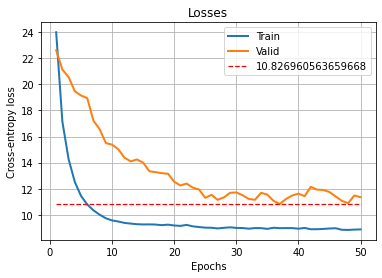

In [ ]:
plot_losses()

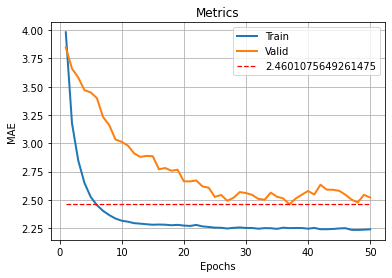

In [ ]:
plot_metrics()

In [ ]:
model = MatrixFactorizationModel(
    60, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 50
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 50


100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


tensor(3.6012)
tensor(7.3268)
tensor(11.0804)

Training loss: 23.054
Validation loss: 21.324
Training MAE: 3.883434772491455
Validation MAE: 3.693481683731079

 Epoch2 / 50


100%|██████████| 3/3 [00:00<00:00,  9.99it/s]


tensor(3.5578)
tensor(7.0032)
tensor(10.4366)

Training loss: 15.458
Validation loss: 19.660
Training MAE: 2.9855682849884033
Validation MAE: 3.4788706302642822

 Epoch3 / 50


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


tensor(3.3624)
tensor(6.7465)
tensor(10.0948)

Training loss: 12.322
Validation loss: 18.377
Training MAE: 2.6254594326019287
Validation MAE: 3.364927291870117

 Epoch4 / 50


100%|██████████| 3/3 [00:00<00:00, 10.04it/s]

tensor(3.1027)
tensor(6.4413)
tensor(9.6040)



Training loss: 10.774
Validation loss: 17.114
Training MAE: 2.45047926902771
Validation MAE: 3.2013299465179443

 Epoch5 / 50


100%|██████████| 3/3 [00:00<00:00,  9.86it/s]

tensor(3.1677)
tensor(6.4543)
tensor(9.4554)



Training loss: 9.805
Validation loss: 16.606
Training MAE: 2.3397762775421143
Validation MAE: 3.151797294616699

 Epoch6 / 50


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


tensor(3.1373)
tensor(6.1515)
tensor(9.2506)

Training loss: 9.288
Validation loss: 15.933
Training MAE: 2.282874584197998
Validation MAE: 3.083536386489868

 Epoch7 / 50


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]

tensor(3.1283)
tensor(6.2454)
tensor(9.0541)



Training loss: 8.980
Validation loss: 15.516
Training MAE: 2.248020887374878
Validation MAE: 3.0180416107177734

 Epoch8 / 50


100%|██████████| 3/3 [00:00<00:00,  9.97it/s]


tensor(3.0866)
tensor(5.9683)
tensor(9.2531)

Training loss: 8.824
Validation loss: 15.994
Training MAE: 2.228895425796509
Validation MAE: 3.0843505859375

 Epoch9 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.97it/s]

tensor(3.0270)
tensor(5.9513)


100%|██████████| 3/3 [00:00<00:00,  9.25it/s]


tensor(8.9652)

Training loss: 8.695
Validation loss: 15.170
Training MAE: 2.2149815559387207
Validation MAE: 2.9884045124053955

 Epoch10 / 50


100%|██████████| 3/3 [00:00<00:00,  9.87it/s]


tensor(2.7998)
tensor(5.8221)
tensor(8.7371)

Training loss: 8.638
Validation loss: 14.440
Training MAE: 2.2106566429138184
Validation MAE: 2.9123713970184326

 Epoch11 / 50


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


tensor(2.7968)
tensor(5.8107)
tensor(8.5760)

Training loss: 8.510
Validation loss: 13.799
Training MAE: 2.1950385570526123
Validation MAE: 2.8586666584014893

 Epoch12 / 50


100%|██████████| 3/3 [00:00<00:00,  9.87it/s]

tensor(2.8869)
tensor(5.7460)
tensor(8.5292)



Training loss: 8.507
Validation loss: 13.785
Training MAE: 2.1946535110473633
Validation MAE: 2.8430652618408203

 Epoch13 / 50


100%|██████████| 3/3 [00:00<00:00,  9.86it/s]

tensor(2.6918)
tensor(5.5291)
tensor(8.4411)



Training loss: 8.437
Validation loss: 13.536
Training MAE: 2.1880486011505127
Validation MAE: 2.8136990070343018

 Epoch14 / 50


100%|██████████| 3/3 [00:00<00:00,  9.68it/s]

tensor(2.6844)
tensor(5.5530)
tensor(8.3010)



Training loss: 8.399
Validation loss: 13.251
Training MAE: 2.1841163635253906
Validation MAE: 2.766993522644043

 Epoch15 / 50


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


tensor(2.7357)
tensor(5.6297)
tensor(8.4267)

Training loss: 8.342
Validation loss: 13.543
Training MAE: 2.176758050918579
Validation MAE: 2.8089091777801514

 Epoch16 / 50


100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


tensor(2.7631)
tensor(5.5054)
tensor(8.2661)

Training loss: 8.309
Validation loss: 12.941
Training MAE: 2.174344778060913
Validation MAE: 2.7553675174713135

 Epoch17 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.42it/s]

tensor(2.6335)
tensor(5.2360)


100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


tensor(7.8234)

Training loss: 8.234
Validation loss: 11.865
Training MAE: 2.164574384689331
Validation MAE: 2.607794761657715

 Epoch18 / 50


100%|██████████| 3/3 [00:00<00:00,  9.67it/s]


tensor(2.6851)
tensor(5.2916)
tensor(7.8755)

Training loss: 8.244
Validation loss: 11.984
Training MAE: 2.1656997203826904
Validation MAE: 2.625178575515747

 Epoch19 / 50


100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


tensor(2.6242)
tensor(5.2840)
tensor(7.8937)

Training loss: 8.253
Validation loss: 12.080
Training MAE: 2.167513608932495
Validation MAE: 2.6312437057495117

 Epoch20 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.95it/s]

tensor(2.6554)
tensor(5.2194)


100%|██████████| 3/3 [00:00<00:00,  9.25it/s]


tensor(7.7651)

Training loss: 8.247
Validation loss: 11.661
Training MAE: 2.165027141571045
Validation MAE: 2.5883586406707764

 Epoch21 / 50


100%|██████████| 3/3 [00:00<00:00,  9.94it/s]

tensor(2.5947)
tensor(5.1591)
tensor(7.7143)



Training loss: 8.326
Validation loss: 11.642
Training MAE: 2.1758203506469727
Validation MAE: 2.571432113647461

 Epoch22 / 50


100%|██████████| 3/3 [00:00<00:00,  9.67it/s]


tensor(2.6210)
tensor(5.1349)
tensor(7.7758)

Training loss: 8.325
Validation loss: 11.790
Training MAE: 2.1760871410369873
Validation MAE: 2.5919220447540283

 Epoch23 / 50


100%|██████████| 3/3 [00:00<00:00,  9.58it/s]

tensor(2.4319)
tensor(5.0902)
tensor(7.6874)



Training loss: 8.282
Validation loss: 11.503
Training MAE: 2.1708922386169434
Validation MAE: 2.5624516010284424

 Epoch24 / 50


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

tensor(2.5278)
tensor(5.1367)
tensor(7.6150)



Training loss: 8.282
Validation loss: 11.425
Training MAE: 2.1703262329101562
Validation MAE: 2.538329839706421

 Epoch25 / 50


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


tensor(2.4456)
tensor(5.1719)
tensor(7.5805)

Training loss: 8.263
Validation loss: 11.196
Training MAE: 2.168513059616089
Validation MAE: 2.526827096939087

 Epoch26 / 50


100%|██████████| 3/3 [00:00<00:00,  9.34it/s]

tensor(2.5908)
tensor(5.1600)
tensor(7.4412)



Training loss: 8.252
Validation loss: 10.852
Training MAE: 2.1661925315856934
Validation MAE: 2.480394124984741

 Epoch27 / 50


100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


tensor(2.6196)
tensor(5.1169)
tensor(7.5115)

Training loss: 8.255
Validation loss: 11.011
Training MAE: 2.167365550994873
Validation MAE: 2.5038363933563232

 Epoch28 / 50


100%|██████████| 3/3 [00:00<00:00,  9.27it/s]


tensor(2.3966)
tensor(4.9052)
tensor(7.4905)

Training loss: 8.202
Validation loss: 10.927
Training MAE: 2.1610891819000244
Validation MAE: 2.4968454837799072

 Epoch29 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.68it/s]

tensor(2.4956)
tensor(5.0039)


100%|██████████| 3/3 [00:00<00:00,  9.34it/s]


tensor(7.4825)

Training loss: 8.239
Validation loss: 10.909
Training MAE: 2.166396141052246
Validation MAE: 2.4941775798797607

 Epoch30 / 50


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

tensor(2.1678)
tensor(4.7622)
tensor(7.2485)



Training loss: 8.237
Validation loss: 10.319
Training MAE: 2.165727138519287
Validation MAE: 2.4161577224731445

 Epoch31 / 50


100%|██████████| 3/3 [00:00<00:00,  9.79it/s]


tensor(2.3636)
tensor(4.8235)
tensor(7.1851)

Training loss: 8.220
Validation loss: 10.153
Training MAE: 2.1642630100250244
Validation MAE: 2.3950233459472656

 Epoch32 / 50


100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


tensor(2.3738)
tensor(4.8131)
tensor(7.3041)

Training loss: 8.143
Validation loss: 10.607
Training MAE: 2.154899835586548
Validation MAE: 2.4346864223480225

 Epoch33 / 50


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


tensor(2.4040)
tensor(4.9070)
tensor(7.4309)

Training loss: 8.114
Validation loss: 10.682
Training MAE: 2.152000665664673
Validation MAE: 2.476979970932007

 Epoch34 / 50


100%|██████████| 3/3 [00:00<00:00, 10.47it/s]


tensor(2.3168)
tensor(4.6703)
tensor(7.1840)

Training loss: 8.129
Validation loss: 10.239
Training MAE: 2.1527535915374756
Validation MAE: 2.3946757316589355

 Epoch35 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.36it/s]

tensor(2.5504)
tensor(4.7972)


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


tensor(6.9966)

Training loss: 8.144
Validation loss: 9.758
Training MAE: 2.154585599899292
Validation MAE: 2.33219838142395

 Epoch36 / 50


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


tensor(2.4142)
tensor(4.7541)
tensor(7.2427)

Training loss: 8.137
Validation loss: 10.271
Training MAE: 2.154287576675415
Validation MAE: 2.414241075515747

 Epoch37 / 50


100%|██████████| 3/3 [00:00<00:00,  9.27it/s]

tensor(2.4609)
tensor(4.9232)
tensor(7.1407)



Training loss: 8.174
Validation loss: 10.043
Training MAE: 2.158048391342163
Validation MAE: 2.3802196979522705

 Epoch38 / 50


100%|██████████| 3/3 [00:00<00:00,  8.81it/s]

tensor(2.4678)
tensor(4.8092)
tensor(7.2087)



Training loss: 8.228
Validation loss: 10.282
Training MAE: 2.16420841217041
Validation MAE: 2.4028966426849365

 Epoch39 / 50


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


tensor(2.4649)
tensor(4.7954)
tensor(7.1512)

Training loss: 8.235
Validation loss: 10.168
Training MAE: 2.164729595184326
Validation MAE: 2.3837316036224365

 Epoch40 / 50


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


tensor(2.5181)
tensor(4.7866)
tensor(7.1335)

Training loss: 8.215
Validation loss: 10.134
Training MAE: 2.1631381511688232
Validation MAE: 2.3778340816497803

 Epoch41 / 50


100%|██████████| 3/3 [00:00<00:00, 10.49it/s]


tensor(2.4485)
tensor(4.8641)
tensor(7.2027)

Training loss: 8.117
Validation loss: 10.256
Training MAE: 2.15204119682312
Validation MAE: 2.400913953781128

 Epoch42 / 50


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


tensor(2.4365)
tensor(4.9241)
tensor(7.2027)

Training loss: 8.101
Validation loss: 10.356
Training MAE: 2.149125099182129
Validation MAE: 2.400909662246704

 Epoch43 / 50


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


tensor(2.5342)
tensor(4.8920)
tensor(7.2650)

Training loss: 8.160
Validation loss: 10.539
Training MAE: 2.156423330307007
Validation MAE: 2.421678304672241

 Epoch44 / 50


100%|██████████| 3/3 [00:00<00:00,  9.48it/s]


tensor(2.4074)
tensor(4.8325)
tensor(7.3711)

Training loss: 8.261
Validation loss: 10.750
Training MAE: 2.1686689853668213
Validation MAE: 2.4570353031158447

 Epoch45 / 50


100%|██████████| 3/3 [00:00<00:00,  9.69it/s]


tensor(2.5349)
tensor(4.9878)
tensor(7.3417)

Training loss: 8.228
Validation loss: 10.508
Training MAE: 2.1641671657562256
Validation MAE: 2.4472296237945557

 Epoch46 / 50


100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


tensor(2.5125)
tensor(4.7651)
tensor(7.2368)

Training loss: 8.187
Validation loss: 10.246
Training MAE: 2.15954852104187
Validation MAE: 2.41225528717041

 Epoch47 / 50


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


tensor(2.4371)
tensor(4.8260)
tensor(7.2731)

Training loss: 8.186
Validation loss: 10.466
Training MAE: 2.1598711013793945
Validation MAE: 2.4243829250335693

 Epoch48 / 50


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]


tensor(2.3224)
tensor(4.6797)
tensor(7.3099)

Training loss: 8.231
Validation loss: 10.669
Training MAE: 2.164210081100464
Validation MAE: 2.436631679534912

 Epoch49 / 50


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


tensor(2.4349)
tensor(4.8994)
tensor(7.2826)

Training loss: 8.297
Validation loss: 10.413
Training MAE: 2.171063184738159
Validation MAE: 2.427518129348755

 Epoch50 / 50


100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

tensor(2.4294)
tensor(4.8978)
tensor(7.2318)

Training loss: 8.249
Validation loss: 10.313
Training MAE: 2.1662964820861816
Validation MAE: 2.4106132984161377


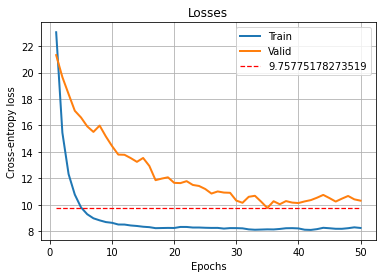

In [ ]:
plot_losses()

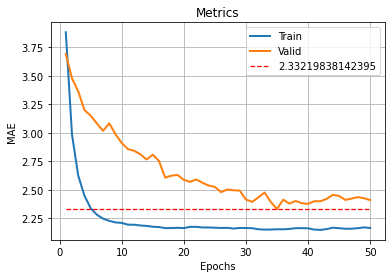

In [ ]:
plot_metrics()

In [ ]:
model = MatrixFactorizationModel(
    40, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 50
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 50


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


tensor(3.3595)
tensor(6.8799)
tensor(10.3313)

Training loss: 20.708
Validation loss: 18.855
Training MAE: 3.6338284015655518
Validation MAE: 3.4437601566314697

 Epoch2 / 50


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


tensor(3.1000)
tensor(6.3005)
tensor(9.4228)

Training loss: 12.276
Validation loss: 16.401
Training MAE: 2.6153206825256348
Validation MAE: 3.1409223079681396

 Epoch3 / 50


100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


tensor(2.9631)
tensor(5.8978)
tensor(8.9331)

Training loss: 9.396
Validation loss: 14.891
Training MAE: 2.2813215255737305
Validation MAE: 2.977689504623413

 Epoch4 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.15it/s]

tensor(2.8411)
tensor(5.6436)


100%|██████████| 3/3 [00:00<00:00,  9.64it/s]


tensor(8.6537)

Training loss: 8.242
Validation loss: 14.283
Training MAE: 2.149000406265259
Validation MAE: 2.884551763534546

 Epoch5 / 50


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]


tensor(2.6804)
tensor(5.4050)
tensor(8.2888)

Training loss: 7.783
Validation loss: 13.030
Training MAE: 2.0962541103363037
Validation MAE: 2.762949228286743

 Epoch6 / 50


100%|██████████| 3/3 [00:00<00:00, 10.00it/s]


tensor(2.6860)
tensor(5.3828)
tensor(8.2316)

Training loss: 7.466
Validation loss: 12.871
Training MAE: 2.0581865310668945
Validation MAE: 2.743849992752075

 Epoch7 / 50


100%|██████████| 3/3 [00:00<00:00,  9.78it/s]

tensor(2.6826)
tensor(5.3430)
tensor(7.9820)



Training loss: 7.291
Validation loss: 12.160
Training MAE: 2.0393948554992676
Validation MAE: 2.6606528759002686

 Epoch8 / 50


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


tensor(2.6367)
tensor(5.2206)
tensor(8.0954)

Training loss: 7.176
Validation loss: 12.443
Training MAE: 2.0253593921661377
Validation MAE: 2.6984689235687256

 Epoch9 / 50


100%|██████████| 3/3 [00:00<00:00,  9.53it/s]

tensor(2.5846)
tensor(5.0965)
tensor(7.6684)



Training loss: 7.073
Validation loss: 11.362
Training MAE: 2.013608694076538
Validation MAE: 2.5561411380767822

 Epoch10 / 50


100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


tensor(2.3853)
tensor(4.8765)
tensor(7.4823)

Training loss: 6.927
Validation loss: 10.689
Training MAE: 1.9932907819747925
Validation MAE: 2.4940879344940186

 Epoch11 / 50


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


tensor(2.3532)
tensor(4.7225)
tensor(7.3304)

Training loss: 6.926
Validation loss: 10.384
Training MAE: 1.9949201345443726
Validation MAE: 2.4434564113616943

 Epoch12 / 50


100%|██████████| 3/3 [00:00<00:00, 10.10it/s]

tensor(2.5987)
tensor(5.0127)
tensor(7.2024)



Training loss: 6.880
Validation loss: 10.140
Training MAE: 1.9889949560165405
Validation MAE: 2.4008095264434814

 Epoch13 / 50


100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


tensor(2.3614)
tensor(4.8783)
tensor(7.2370)

Training loss: 6.867
Validation loss: 10.282
Training MAE: 1.986531138420105
Validation MAE: 2.4123456478118896

 Epoch14 / 50


100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

tensor(2.4059)
tensor(4.8085)
tensor(7.1692)



Training loss: 6.877
Validation loss: 9.865
Training MAE: 1.9883105754852295
Validation MAE: 2.3897454738616943

 Epoch15 / 50


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


tensor(2.5414)
tensor(4.7853)
tensor(7.0093)

Training loss: 6.870
Validation loss: 9.504
Training MAE: 1.9869294166564941
Validation MAE: 2.3364181518554688

 Epoch16 / 50


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


tensor(2.3942)
tensor(4.7699)
tensor(7.1143)

Training loss: 6.897
Validation loss: 9.839
Training MAE: 1.9922126531600952
Validation MAE: 2.371434450149536

 Epoch17 / 50


100%|██████████| 3/3 [00:00<00:00,  9.58it/s]


tensor(2.4829)
tensor(4.7308)
tensor(7.0368)

Training loss: 6.776
Validation loss: 9.624
Training MAE: 1.9745545387268066
Validation MAE: 2.3455963134765625

 Epoch18 / 50


100%|██████████| 3/3 [00:00<00:00,  9.49it/s]

tensor(2.5274)
tensor(4.7697)
tensor(7.1218)



Training loss: 6.768
Validation loss: 9.914
Training MAE: 1.974155306816101
Validation MAE: 2.3739330768585205

 Epoch19 / 50


100%|██████████| 3/3 [00:00<00:00,  9.83it/s]


tensor(2.1814)
tensor(4.6596)
tensor(6.9869)

Training loss: 6.785
Validation loss: 9.637
Training MAE: 1.9779510498046875
Validation MAE: 2.328979253768921

 Epoch20 / 50


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


tensor(2.3413)
tensor(4.6288)
tensor(7.0326)

Training loss: 6.730
Validation loss: 9.669
Training MAE: 1.9667009115219116
Validation MAE: 2.344200849533081

 Epoch21 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  5.18it/s]

tensor(2.2916)
tensor(4.6856)


100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


tensor(6.9832)

Training loss: 6.792
Validation loss: 9.369
Training MAE: 1.9739965200424194
Validation MAE: 2.327742338180542

 Epoch22 / 50


100%|██████████| 3/3 [00:00<00:00,  9.74it/s]

tensor(2.3257)
tensor(4.6187)
tensor(6.8600)



Training loss: 6.750
Validation loss: 9.122
Training MAE: 1.9711989164352417
Validation MAE: 2.286679983139038

 Epoch23 / 50


100%|██████████| 3/3 [00:00<00:00, 10.05it/s]


tensor(2.2411)
tensor(4.5714)
tensor(6.9789)

Training loss: 6.779
Validation loss: 9.466
Training MAE: 1.9748859405517578
Validation MAE: 2.326310873031616

 Epoch24 / 50


100%|██████████| 3/3 [00:00<00:00,  9.53it/s]


tensor(2.2423)
tensor(4.5957)
tensor(6.9929)

Training loss: 6.702
Validation loss: 9.649
Training MAE: 1.9629778861999512
Validation MAE: 2.3309781551361084

 Epoch25 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.49it/s]

tensor(2.3974)
tensor(4.7834)


100%|██████████| 3/3 [00:00<00:00,  8.98it/s]


tensor(7.0885)

Training loss: 6.766
Validation loss: 9.879
Training MAE: 1.9733607769012451
Validation MAE: 2.362823009490967

 Epoch26 / 50


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


tensor(2.3327)
tensor(4.6722)
tensor(7.1637)

Training loss: 6.733
Validation loss: 10.157
Training MAE: 1.9685734510421753
Validation MAE: 2.387911796569824

 Epoch27 / 50


100%|██████████| 3/3 [00:00<00:00,  9.54it/s]


tensor(2.3567)
tensor(4.6150)
tensor(7.0031)

Training loss: 6.763
Validation loss: 9.602
Training MAE: 1.9720790386199951
Validation MAE: 2.334371328353882

 Epoch28 / 50


100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


tensor(2.1875)
tensor(4.5151)
tensor(7.0398)

Training loss: 6.746
Validation loss: 9.757
Training MAE: 1.9709378480911255
Validation MAE: 2.346595525741577

 Epoch29 / 50


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


tensor(2.2649)
tensor(4.7648)
tensor(6.8852)

Training loss: 6.812
Validation loss: 9.385
Training MAE: 1.9783490896224976
Validation MAE: 2.295069694519043

 Epoch30 / 50


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]


tensor(2.3515)
tensor(4.7408)
tensor(6.8349)

Training loss: 6.754
Validation loss: 9.374
Training MAE: 1.9704538583755493
Validation MAE: 2.2783145904541016

 Epoch31 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.66it/s]

tensor(2.4282)
tensor(4.6945)


100%|██████████| 3/3 [00:00<00:00,  9.44it/s]


tensor(6.8944)

Training loss: 6.782
Validation loss: 9.431
Training MAE: 1.9744877815246582
Validation MAE: 2.2981250286102295

 Epoch32 / 50


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


tensor(2.2638)
tensor(4.5278)
tensor(6.8965)

Training loss: 6.773
Validation loss: 9.413
Training MAE: 1.9717293977737427
Validation MAE: 2.2988412380218506

 Epoch33 / 50


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


tensor(2.3406)
tensor(4.7801)
tensor(6.8733)

Training loss: 6.742
Validation loss: 9.234
Training MAE: 1.9670357704162598
Validation MAE: 2.2910845279693604

 Epoch34 / 50


100%|██████████| 3/3 [00:00<00:00, 10.40it/s]


tensor(2.3742)
tensor(4.6012)
tensor(6.9034)

Training loss: 6.780
Validation loss: 9.373
Training MAE: 1.9731956720352173
Validation MAE: 2.301147222518921

 Epoch35 / 50


100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


tensor(2.2999)
tensor(4.7342)
tensor(6.9507)

Training loss: 6.766
Validation loss: 9.455
Training MAE: 1.9718281030654907
Validation MAE: 2.316890001296997

 Epoch36 / 50


100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


tensor(2.3661)
tensor(4.6164)
tensor(6.9109)

Training loss: 6.802
Validation loss: 9.325
Training MAE: 1.9769572019577026
Validation MAE: 2.303616762161255

 Epoch37 / 50


100%|██████████| 3/3 [00:00<00:00,  9.71it/s]

tensor(2.2087)
tensor(4.4523)
tensor(6.7693)



Training loss: 6.800
Validation loss: 9.023
Training MAE: 1.976487398147583
Validation MAE: 2.256441354751587

 Epoch38 / 50


100%|██████████| 3/3 [00:00<00:00, 10.37it/s]


tensor(2.3156)
tensor(4.5235)
tensor(6.7466)

Training loss: 6.809
Validation loss: 9.048
Training MAE: 1.976675033569336
Validation MAE: 2.2488646507263184

 Epoch39 / 50


100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


tensor(2.2958)
tensor(4.6717)
tensor(6.7170)

Training loss: 6.804
Validation loss: 8.805
Training MAE: 1.9758918285369873
Validation MAE: 2.238986015319824

 Epoch40 / 50


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


tensor(2.3337)
tensor(4.5857)
tensor(6.9529)

Training loss: 6.832
Validation loss: 9.324
Training MAE: 1.9789718389511108
Validation MAE: 2.317621946334839

 Epoch41 / 50


100%|██████████| 3/3 [00:00<00:00, 10.31it/s]


tensor(2.3079)
tensor(4.5461)
tensor(6.9638)

Training loss: 6.818
Validation loss: 9.472
Training MAE: 1.9778918027877808
Validation MAE: 2.3212637901306152

 Epoch42 / 50


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


tensor(2.3792)
tensor(4.7692)
tensor(7.0841)

Training loss: 6.792
Validation loss: 9.799
Training MAE: 1.9739969968795776
Validation MAE: 2.361361265182495

 Epoch43 / 50


100%|██████████| 3/3 [00:00<00:00, 10.47it/s]


tensor(2.2937)
tensor(4.6041)
tensor(7.1354)

Training loss: 6.930
Validation loss: 9.882
Training MAE: 1.9919865131378174
Validation MAE: 2.3784539699554443

 Epoch44 / 50


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


tensor(2.4417)
tensor(4.7178)
tensor(6.9304)

Training loss: 6.831
Validation loss: 9.481
Training MAE: 1.9767636060714722
Validation MAE: 2.310121774673462

 Epoch45 / 50


100%|██████████| 3/3 [00:00<00:00,  9.53it/s]


tensor(2.3070)
tensor(4.6227)
tensor(6.9080)

Training loss: 6.784
Validation loss: 9.353
Training MAE: 1.9713108539581299
Validation MAE: 2.3026790618896484

 Epoch46 / 50


100%|██████████| 3/3 [00:00<00:00,  9.03it/s]

tensor(2.2817)
tensor(4.5635)
tensor(6.8345)



Training loss: 6.799
Validation loss: 9.215
Training MAE: 1.9727436304092407
Validation MAE: 2.2781808376312256

 Epoch47 / 50


100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


tensor(2.2024)
tensor(4.4398)
tensor(6.8256)

Training loss: 6.845
Validation loss: 9.182
Training MAE: 1.9798182249069214
Validation MAE: 2.275207281112671

 Epoch48 / 50


100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


tensor(2.2896)
tensor(4.5366)
tensor(6.7305)

Training loss: 6.808
Validation loss: 8.862
Training MAE: 1.9732567071914673
Validation MAE: 2.2434842586517334

 Epoch49 / 50


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


tensor(2.3216)
tensor(4.6081)
tensor(6.8193)

Training loss: 6.795
Validation loss: 9.183
Training MAE: 1.968709111213684
Validation MAE: 2.273113489151001

 Epoch50 / 50


100%|██████████| 3/3 [00:00<00:00,  9.95it/s]

tensor(2.2683)
tensor(4.6285)
tensor(7.0335)

Training loss: 6.830
Validation loss: 9.612
Training MAE: 1.9758449792861938
Validation MAE: 2.3445093631744385


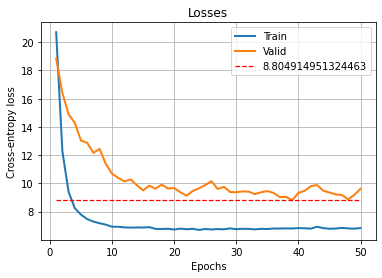

In [ ]:
plot_losses()

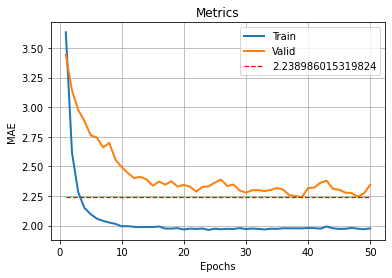

In [ ]:
plot_metrics()

In [ ]:
model = MatrixFactorizationModel(
    40, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 50
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')

all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 50


100%|██████████| 3/3 [00:00<00:00,  9.51it/s]

tensor(3.9755)
tensor(7.6116)
tensor(11.6071)



Training loss: 23.206
Validation loss: 22.790
Training MAE: 3.919389009475708
Validation MAE: 3.869039535522461

 Epoch2 / 50


100%|██████████| 3/3 [00:00<00:00,  9.87it/s]


tensor(3.7330)
tensor(7.6061)
tensor(11.2434)

Training loss: 16.175
Validation loss: 21.669
Training MAE: 3.000253200531006
Validation MAE: 3.7478067874908447

 Epoch3 / 50


100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

tensor(3.5743)
tensor(7.3769)
tensor(11.0855)



Training loss: 12.229
Validation loss: 21.166
Training MAE: 2.480240821838379
Validation MAE: 3.6951770782470703

 Epoch4 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.98it/s]

tensor(3.7033)
tensor(7.3539)


100%|██████████| 3/3 [00:00<00:00,  9.22it/s]


tensor(10.8125)

Training loss: 10.233
Validation loss: 20.362
Training MAE: 2.225856065750122
Validation MAE: 3.60416579246521

 Epoch5 / 50


100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

tensor(3.5210)
tensor(7.1503)
tensor(10.7419)



Training loss: 8.961
Validation loss: 20.053
Training MAE: 2.0682389736175537
Validation MAE: 3.580631971359253

 Epoch6 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.92it/s]

tensor(3.5436)
tensor(7.0320)


100%|██████████| 3/3 [00:00<00:00,  8.67it/s]


tensor(10.5123)

Training loss: 7.987
Validation loss: 19.400
Training MAE: 1.9468311071395874
Validation MAE: 3.5040838718414307

 Epoch7 / 50


100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


tensor(3.5619)
tensor(6.8985)
tensor(10.5304)

Training loss: 7.157
Validation loss: 19.351
Training MAE: 1.840088963508606
Validation MAE: 3.5101497173309326

 Epoch8 / 50


100%|██████████| 3/3 [00:00<00:00,  8.74it/s]

tensor(3.3716)
tensor(6.7958)
tensor(10.3178)



Training loss: 6.452
Validation loss: 18.825
Training MAE: 1.739235758781433
Validation MAE: 3.4392786026000977

 Epoch9 / 50


100%|██████████| 3/3 [00:00<00:00,  9.49it/s]


tensor(3.2688)
tensor(6.7583)
tensor(10.1010)

Training loss: 5.897
Validation loss: 18.127
Training MAE: 1.6571075916290283
Validation MAE: 3.3670012950897217

 Epoch10 / 50


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


tensor(3.3534)
tensor(6.5843)
tensor(9.9998)

Training loss: 5.379
Validation loss: 17.725
Training MAE: 1.5761653184890747
Validation MAE: 3.3332645893096924

 Epoch11 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.48it/s]

tensor(3.3197)
tensor(6.6637)


100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


tensor(9.7934)

Training loss: 4.888
Validation loss: 17.189
Training MAE: 1.4994827508926392
Validation MAE: 3.264458656311035

 Epoch12 / 50


100%|██████████| 3/3 [00:00<00:00,  9.86it/s]


tensor(3.1274)
tensor(6.4619)
tensor(9.7693)

Training loss: 4.452
Validation loss: 17.109
Training MAE: 1.4268085956573486
Validation MAE: 3.256422996520996

 Epoch13 / 50


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


tensor(3.2954)
tensor(6.4924)
tensor(9.5320)

Training loss: 4.052
Validation loss: 16.301
Training MAE: 1.3519268035888672
Validation MAE: 3.1773273944854736

 Epoch14 / 50


100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

tensor(3.2293)
tensor(6.3941)
tensor(9.3798)



Training loss: 3.680
Validation loss: 15.828
Training MAE: 1.2793121337890625
Validation MAE: 3.126598596572876

 Epoch15 / 50


100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


tensor(3.1830)
tensor(6.2181)
tensor(9.4589)

Training loss: 3.356
Validation loss: 15.959
Training MAE: 1.2141282558441162
Validation MAE: 3.1529502868652344

 Epoch16 / 50


100%|██████████| 3/3 [00:00<00:00,  9.16it/s]


tensor(3.0929)
tensor(6.0884)
tensor(9.2808)

Training loss: 3.068
Validation loss: 15.557
Training MAE: 1.155685544013977
Validation MAE: 3.0936033725738525

 Epoch17 / 50


100%|██████████| 3/3 [00:00<00:00, 10.38it/s]


tensor(2.9801)
tensor(5.9529)
tensor(9.1696)

Training loss: 2.756
Validation loss: 15.240
Training MAE: 1.0890876054763794
Validation MAE: 3.0565288066864014

 Epoch18 / 50


100%|██████████| 3/3 [00:00<00:00, 10.27it/s]


tensor(2.9132)
tensor(5.9312)
tensor(9.0102)

Training loss: 2.510
Validation loss: 14.750
Training MAE: 1.034050703048706
Validation MAE: 3.0033912658691406

 Epoch19 / 50


100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

tensor(3.0038)
tensor(5.8531)
tensor(8.9631)



Training loss: 2.283
Validation loss: 14.545
Training MAE: 0.9821786284446716
Validation MAE: 2.9877045154571533

 Epoch20 / 50


100%|██████████| 3/3 [00:00<00:00,  9.96it/s]

tensor(2.9311)
tensor(5.8144)
tensor(8.7119)



Training loss: 2.060
Validation loss: 13.928
Training MAE: 0.928856611251831
Validation MAE: 2.9039523601531982

 Epoch21 / 50


100%|██████████| 3/3 [00:00<00:00,  9.87it/s]


tensor(2.7311)
tensor(5.7162)
tensor(8.5156)

Training loss: 1.875
Validation loss: 13.444
Training MAE: 0.8810850381851196
Validation MAE: 2.8385403156280518

 Epoch22 / 50


100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


tensor(2.8643)
tensor(5.6269)
tensor(8.4707)

Training loss: 1.695
Validation loss: 13.325
Training MAE: 0.835628092288971
Validation MAE: 2.8235576152801514

 Epoch23 / 50


100%|██████████| 3/3 [00:00<00:00,  9.87it/s]


tensor(2.7589)
tensor(5.5250)
tensor(8.3764)

Training loss: 1.544
Validation loss: 12.944
Training MAE: 0.7949212193489075
Validation MAE: 2.792137861251831

 Epoch24 / 50


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

tensor(2.7244)
tensor(5.3933)
tensor(8.2637)



Training loss: 1.413
Validation loss: 12.659
Training MAE: 0.7584169507026672
Validation MAE: 2.75456166267395

 Epoch25 / 50


100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


tensor(2.7839)
tensor(5.3730)
tensor(8.0802)

Training loss: 1.282
Validation loss: 12.202
Training MAE: 0.7222187519073486
Validation MAE: 2.6933908462524414

 Epoch26 / 50


100%|██████████| 3/3 [00:00<00:00,  9.66it/s]


tensor(2.6169)
tensor(5.2838)
tensor(7.9501)

Training loss: 1.164
Validation loss: 11.818
Training MAE: 0.6885271668434143
Validation MAE: 2.6500184535980225

 Epoch27 / 50


100%|██████████| 3/3 [00:00<00:00,  9.33it/s]

tensor(2.6361)
tensor(5.1945)
tensor(7.7555)



Training loss: 1.056
Validation loss: 11.251
Training MAE: 0.6569067239761353
Validation MAE: 2.585172414779663

 Epoch28 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.91it/s]

tensor(2.6711)
tensor(5.1775)


100%|██████████| 3/3 [00:00<00:00,  8.96it/s]


tensor(7.6020)

Training loss: 0.968
Validation loss: 10.770
Training MAE: 0.6315239667892456
Validation MAE: 2.534005880355835

 Epoch29 / 50


100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


tensor(2.4316)
tensor(4.9884)
tensor(7.5184)

Training loss: 0.878
Validation loss: 10.745
Training MAE: 0.6017448902130127
Validation MAE: 2.506136417388916

 Epoch30 / 50


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


tensor(2.4663)
tensor(4.9595)
tensor(7.4083)

Training loss: 0.803
Validation loss: 10.323
Training MAE: 0.5771214962005615
Validation MAE: 2.4694225788116455

 Epoch31 / 50


100%|██████████| 3/3 [00:00<00:00,  9.95it/s]

tensor(2.5084)
tensor(4.9189)
tensor(7.2504)



Training loss: 0.730
Validation loss: 10.017
Training MAE: 0.5515820980072021
Validation MAE: 2.416785478591919

 Epoch32 / 50


100%|██████████| 3/3 [00:00<00:00,  9.96it/s]


tensor(2.3692)
tensor(4.7669)
tensor(7.2413)

Training loss: 0.690
Validation loss: 9.867
Training MAE: 0.5351101160049438
Validation MAE: 2.413757562637329

 Epoch33 / 50


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]


tensor(2.3526)
tensor(4.7228)
tensor(6.9833)

Training loss: 0.629
Validation loss: 9.363
Training MAE: 0.514270007610321
Validation MAE: 2.3277761936187744

 Epoch34 / 50


100%|██████████| 3/3 [00:00<00:00,  9.79it/s]


tensor(2.4374)
tensor(4.7113)
tensor(6.8949)

Training loss: 0.579
Validation loss: 9.138
Training MAE: 0.4968108534812927
Validation MAE: 2.2983028888702393

 Epoch35 / 50


100%|██████████| 3/3 [00:00<00:00, 10.01it/s]

tensor(2.3253)
tensor(4.5469)
tensor(6.8001)



Training loss: 0.546
Validation loss: 8.861
Training MAE: 0.4831012785434723
Validation MAE: 2.2667076587677

 Epoch36 / 50


100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


tensor(2.2101)
tensor(4.4004)
tensor(6.8059)

Training loss: 0.503
Validation loss: 8.819
Training MAE: 0.46802327036857605
Validation MAE: 2.268622875213623

 Epoch37 / 50


100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

tensor(2.0710)
tensor(4.2830)
tensor(6.7087)



Training loss: 0.472
Validation loss: 8.573
Training MAE: 0.45736780762672424
Validation MAE: 2.2362213134765625

 Epoch38 / 50


100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


tensor(2.0835)
tensor(4.3798)
tensor(6.5003)

Training loss: 0.447
Validation loss: 8.137
Training MAE: 0.4467051327228546
Validation MAE: 2.1667673587799072

 Epoch39 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.76it/s]

tensor(2.0229)
tensor(4.1688)


100%|██████████| 3/3 [00:00<00:00,  9.06it/s]


tensor(6.4480)

Training loss: 0.425
Validation loss: 7.968
Training MAE: 0.4375632703304291
Validation MAE: 2.149348020553589

 Epoch40 / 50


100%|██████████| 3/3 [00:00<00:00,  9.68it/s]

tensor(1.9884)
tensor(4.1474)
tensor(6.3533)



Training loss: 0.402
Validation loss: 7.847
Training MAE: 0.42806148529052734
Validation MAE: 2.117769479751587

 Epoch41 / 50


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


tensor(2.1372)
tensor(4.1154)
tensor(6.1799)

Training loss: 0.385
Validation loss: 7.331
Training MAE: 0.4210284948348999
Validation MAE: 2.0599634647369385

 Epoch42 / 50


100%|██████████| 3/3 [00:00<00:00, 10.02it/s]


tensor(2.0690)
tensor(4.1367)
tensor(6.0531)

Training loss: 0.368
Validation loss: 7.137
Training MAE: 0.4135366380214691
Validation MAE: 2.0176842212677

 Epoch43 / 50


100%|██████████| 3/3 [00:00<00:00,  9.70it/s]

tensor(2.0263)
tensor(3.9415)
tensor(6.0236)



Training loss: 0.354
Validation loss: 7.005
Training MAE: 0.40723100304603577
Validation MAE: 2.0078718662261963

 Epoch44 / 50


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


tensor(1.9937)
tensor(3.9773)
tensor(5.8656)

Training loss: 0.338
Validation loss: 6.690
Training MAE: 0.39971473813056946
Validation MAE: 1.9552165269851685

 Epoch45 / 50


100%|██████████| 3/3 [00:00<00:00,  9.83it/s]


tensor(1.8815)
tensor(3.8708)
tensor(5.8003)

Training loss: 0.329
Validation loss: 6.485
Training MAE: 0.395224392414093
Validation MAE: 1.933448314666748

 Epoch46 / 50


100%|██████████| 3/3 [00:00<00:00,  8.82it/s]

tensor(1.8831)
tensor(3.8636)
tensor(5.7493)



Training loss: 0.320
Validation loss: 6.420
Training MAE: 0.39193522930145264
Validation MAE: 1.9164212942123413

 Epoch47 / 50


100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


tensor(2.0650)
tensor(3.8009)
tensor(5.6412)

Training loss: 0.314
Validation loss: 6.202
Training MAE: 0.38904422521591187
Validation MAE: 1.8804155588150024

 Epoch48 / 50


100%|██████████| 3/3 [00:00<00:00, 10.05it/s]


tensor(1.8569)
tensor(3.7410)
tensor(5.6713)

Training loss: 0.305
Validation loss: 6.296
Training MAE: 0.3852134346961975
Validation MAE: 1.8904460668563843

 Epoch49 / 50


100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

tensor(1.8888)
tensor(3.7141)
tensor(5.5324)



Training loss: 0.297
Validation loss: 5.920
Training MAE: 0.38100871443748474
Validation MAE: 1.8441308736801147

 Epoch50 / 50


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]

tensor(1.7328)
tensor(3.5681)
tensor(5.5238)



Training loss: 0.287
Validation loss: 5.886
Training MAE: 0.37609589099884033
Validation MAE: 1.841267466545105


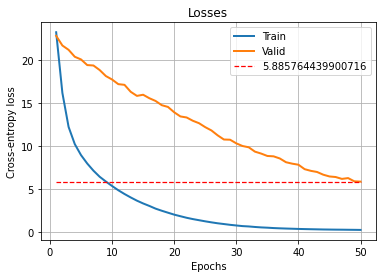

In [ ]:
plot_losses()

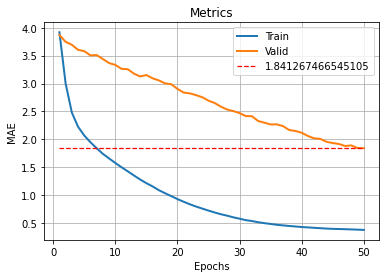

In [ ]:
plot_metrics()

In [ ]:
model = MatrixFactorizationModel(
    40, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.04)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 50
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')

all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 50


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


tensor(3.6500)
tensor(7.0215)
tensor(10.5676)

Training loss: 21.405
Validation loss: 19.635
Training MAE: 3.718191385269165
Validation MAE: 3.5225322246551514

 Epoch2 / 50


100%|██████████| 3/3 [00:00<00:00,  9.48it/s]


tensor(3.2140)
tensor(6.4410)
tensor(9.7894)

Training loss: 12.461
Validation loss: 17.512
Training MAE: 2.634064197540283
Validation MAE: 3.263127565383911

 Epoch3 / 50


100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


tensor(3.1164)
tensor(6.1879)
tensor(9.2147)

Training loss: 9.316
Validation loss: 15.940
Training MAE: 2.2630577087402344
Validation MAE: 3.0715830326080322

 Epoch4 / 50


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]

tensor(2.9727)
tensor(5.8184)
tensor(8.8623)



Training loss: 7.946
Validation loss: 14.907
Training MAE: 2.105095386505127
Validation MAE: 2.954115629196167

 Epoch5 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.64it/s]

tensor(2.7826)
tensor(5.6825)
tensor(8.4583)


100%|██████████| 3/3 [00:00<00:00,  8.96it/s]



Training loss: 7.368
Validation loss: 13.681
Training MAE: 2.037571668624878
Validation MAE: 2.819448709487915

 Epoch6 / 50


100%|██████████| 3/3 [00:00<00:00,  9.76it/s]


tensor(2.5698)
tensor(5.4413)
tensor(8.1961)

Training loss: 6.920
Validation loss: 13.073
Training MAE: 1.9828152656555176
Validation MAE: 2.732020616531372

 Epoch7 / 50


100%|██████████| 3/3 [00:00<00:00,  9.75it/s]

tensor(2.6671)
tensor(5.2918)
tensor(8.0386)



Training loss: 6.679
Validation loss: 12.280
Training MAE: 1.9517868757247925
Validation MAE: 2.6795406341552734

 Epoch8 / 50


100%|██████████| 3/3 [00:00<00:00, 10.23it/s]


tensor(2.7998)
tensor(5.2905)
tensor(7.8625)

Training loss: 6.495
Validation loss: 11.681
Training MAE: 1.926234483718872
Validation MAE: 2.620824098587036

 Epoch9 / 50


100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


tensor(2.4750)
tensor(5.0524)
tensor(7.4943)

Training loss: 6.298
Validation loss: 10.935
Training MAE: 1.8988842964172363
Validation MAE: 2.49811053276062

 Epoch10 / 50


100%|██████████| 3/3 [00:00<00:00,  9.51it/s]

tensor(2.2935)
tensor(4.8265)
tensor(7.3779)



Training loss: 6.158
Validation loss: 10.523
Training MAE: 1.8796743154525757
Validation MAE: 2.4592840671539307

 Epoch11 / 50


100%|██████████| 3/3 [00:00<00:00,  9.93it/s]

tensor(2.3798)
tensor(4.7669)
tensor(7.1568)



Training loss: 6.085
Validation loss: 9.949
Training MAE: 1.8664671182632446
Validation MAE: 2.3856019973754883

 Epoch12 / 50


100%|██████████| 3/3 [00:00<00:00,  8.99it/s]

tensor(2.2574)
tensor(4.7054)
tensor(7.0079)



Training loss: 6.019
Validation loss: 9.539
Training MAE: 1.8536845445632935
Validation MAE: 2.335963249206543

 Epoch13 / 50


100%|██████████| 3/3 [00:00<00:00, 10.30it/s]


tensor(2.3101)
tensor(4.5569)
tensor(6.9878)

Training loss: 5.912
Validation loss: 9.467
Training MAE: 1.8366146087646484
Validation MAE: 2.3292694091796875

 Epoch14 / 50


100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


tensor(2.2733)
tensor(4.6957)
tensor(6.9833)

Training loss: 5.818
Validation loss: 9.546
Training MAE: 1.8208705186843872
Validation MAE: 2.32776141166687

 Epoch15 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  7.55it/s]

tensor(2.1669)
tensor(4.4913)


100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


tensor(6.7547)

Training loss: 5.795
Validation loss: 9.027
Training MAE: 1.8164242506027222
Validation MAE: 2.251570463180542

 Epoch16 / 50


100%|██████████| 3/3 [00:00<00:00, 10.35it/s]


tensor(2.1979)
tensor(4.4178)
tensor(6.7033)

Training loss: 5.773
Validation loss: 8.824
Training MAE: 1.8129158020019531
Validation MAE: 2.234428644180298

 Epoch17 / 50


100%|██████████| 3/3 [00:00<00:00,  9.37it/s]

tensor(2.3262)
tensor(4.5597)
tensor(6.8307)



Training loss: 5.673
Validation loss: 9.084
Training MAE: 1.7972663640975952
Validation MAE: 2.2769110202789307

 Epoch18 / 50


100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


tensor(2.2955)
tensor(4.5133)
tensor(6.6796)

Training loss: 5.636
Validation loss: 8.892
Training MAE: 1.7894188165664673
Validation MAE: 2.2265384197235107

 Epoch19 / 50


100%|██████████| 3/3 [00:00<00:00,  9.80it/s]

tensor(2.2117)
tensor(4.4202)
tensor(6.5667)



Training loss: 5.621
Validation loss: 8.462
Training MAE: 1.786818027496338
Validation MAE: 2.1889095306396484

 Epoch20 / 50


100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

tensor(2.2838)
tensor(4.4575)
tensor(6.4819)



Training loss: 5.534
Validation loss: 8.289
Training MAE: 1.7739351987838745
Validation MAE: 2.1606438159942627

 Epoch21 / 50


100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


tensor(2.1205)
tensor(4.3284)
tensor(6.4145)

Training loss: 5.475
Validation loss: 8.129
Training MAE: 1.7628835439682007
Validation MAE: 2.1381781101226807

 Epoch22 / 50


100%|██████████| 3/3 [00:00<00:00,  9.73it/s]

tensor(2.1265)
tensor(4.2753)
tensor(6.4457)



Training loss: 5.476
Validation loss: 7.917
Training MAE: 1.762743592262268
Validation MAE: 2.1485748291015625

 Epoch23 / 50


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


tensor(2.1110)
tensor(4.3036)
tensor(6.4795)

Training loss: 5.528
Validation loss: 8.201
Training MAE: 1.768927812576294
Validation MAE: 2.1598312854766846

 Epoch24 / 50


100%|██████████| 3/3 [00:00<00:00,  9.34it/s]


tensor(2.2458)
tensor(4.3322)
tensor(6.3625)

Training loss: 5.419
Validation loss: 7.989
Training MAE: 1.7521075010299683
Validation MAE: 2.120823860168457

 Epoch25 / 50


100%|██████████| 3/3 [00:00<00:00, 10.23it/s]


tensor(2.1000)
tensor(4.2466)
tensor(6.4408)

Training loss: 5.455
Validation loss: 8.053
Training MAE: 1.7552469968795776
Validation MAE: 2.14693546295166

 Epoch26 / 50


100%|██████████| 3/3 [00:00<00:00,  9.64it/s]


tensor(2.1318)
tensor(4.3324)
tensor(6.4032)

Training loss: 5.348
Validation loss: 7.902
Training MAE: 1.7402851581573486
Validation MAE: 2.1344010829925537

 Epoch27 / 50


100%|██████████| 3/3 [00:00<00:00, 10.27it/s]


tensor(2.2462)
tensor(4.2984)
tensor(6.4296)

Training loss: 5.362
Validation loss: 8.074
Training MAE: 1.7423239946365356
Validation MAE: 2.1431987285614014

 Epoch28 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  8.36it/s]

tensor(2.2010)
tensor(4.3388)


100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


tensor(6.5200)

Training loss: 5.339
Validation loss: 8.458
Training MAE: 1.73539137840271
Validation MAE: 2.173318386077881

 Epoch29 / 50


100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


tensor(2.1696)
tensor(4.3702)
tensor(6.3890)

Training loss: 5.334
Validation loss: 8.019
Training MAE: 1.7327958345413208
Validation MAE: 2.129654884338379

 Epoch30 / 50


100%|██████████| 3/3 [00:00<00:00, 10.27it/s]


tensor(2.0452)
tensor(4.1615)
tensor(6.3846)

Training loss: 5.318
Validation loss: 8.013
Training MAE: 1.728148341178894
Validation MAE: 2.128202199935913

 Epoch31 / 50


 67%|██████▋   | 2/3 [00:00<00:00,  6.22it/s]

tensor(2.0483)
tensor(4.2040)


100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


tensor(6.2825)

Training loss: 5.290
Validation loss: 7.697
Training MAE: 1.7240118980407715
Validation MAE: 2.0941545963287354

 Epoch32 / 50


100%|██████████| 3/3 [00:00<00:00,  9.96it/s]

tensor(2.0797)
tensor(4.2827)
tensor(6.2861)



Training loss: 5.256
Validation loss: 7.641
Training MAE: 1.7178932428359985
Validation MAE: 2.095362901687622

 Epoch33 / 50


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


tensor(2.0597)
tensor(4.1964)
tensor(6.2515)

Training loss: 5.303
Validation loss: 7.630
Training MAE: 1.7233465909957886
Validation MAE: 2.0838229656219482

 Epoch34 / 50


100%|██████████| 3/3 [00:00<00:00,  9.82it/s]


tensor(2.1079)
tensor(4.1760)
tensor(6.2940)

Training loss: 5.261
Validation loss: 7.827
Training MAE: 1.72005033493042
Validation MAE: 2.0979835987091064

 Epoch35 / 50


100%|██████████| 3/3 [00:00<00:00, 10.30it/s]


tensor(2.1734)
tensor(4.1456)
tensor(6.2859)

Training loss: 5.254
Validation loss: 7.761
Training MAE: 1.7173116207122803
Validation MAE: 2.0953121185302734

 Epoch36 / 50


100%|██████████| 3/3 [00:00<00:00,  9.15it/s]


tensor(2.1140)
tensor(4.1819)
tensor(6.2683)

Training loss: 5.202
Validation loss: 7.656
Training MAE: 1.7111989259719849
Validation MAE: 2.089449167251587

 Epoch37 / 50


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


tensor(2.1338)
tensor(4.2907)
tensor(6.5514)

Training loss: 5.242
Validation loss: 8.298
Training MAE: 1.7159045934677124
Validation MAE: 2.183786630630493

 Epoch38 / 50


100%|██████████| 3/3 [00:00<00:00, 10.06it/s]


tensor(2.0782)
tensor(4.3529)
tensor(6.3727)

Training loss: 5.221
Validation loss: 7.902
Training MAE: 1.7098976373672485
Validation MAE: 2.1242473125457764

 Epoch39 / 50


100%|██████████| 3/3 [00:00<00:00, 10.22it/s]


tensor(2.1996)
tensor(4.3101)
tensor(6.4808)

Training loss: 5.241
Validation loss: 8.332
Training MAE: 1.7123976945877075
Validation MAE: 2.1602659225463867

 Epoch40 / 50


100%|██████████| 3/3 [00:00<00:00,  9.97it/s]


tensor(2.1361)
tensor(4.3286)
tensor(6.4096)

Training loss: 5.203
Validation loss: 8.047
Training MAE: 1.708611011505127
Validation MAE: 2.1365277767181396

 Epoch41 / 50


100%|██████████| 3/3 [00:00<00:00,  9.70it/s]


tensor(2.1162)
tensor(4.2962)
tensor(6.3303)

Training loss: 5.204
Validation loss: 7.827
Training MAE: 1.7073273658752441
Validation MAE: 2.1100852489471436

 Epoch42 / 50


100%|██████████| 3/3 [00:00<00:00, 10.50it/s]


tensor(2.2002)
tensor(4.0776)
tensor(6.4956)

Training loss: 5.209
Validation loss: 8.228
Training MAE: 1.7068159580230713
Validation MAE: 2.165193557739258

 Epoch43 / 50


100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


tensor(2.0920)
tensor(4.2554)
tensor(6.3286)

Training loss: 5.150
Validation loss: 7.940
Training MAE: 1.699332356452942
Validation MAE: 2.1095478534698486

 Epoch44 / 50


100%|██████████| 3/3 [00:00<00:00, 10.00it/s]


tensor(2.1679)
tensor(4.2572)
tensor(6.2227)

Training loss: 5.157
Validation loss: 7.609
Training MAE: 1.6981664896011353
Validation MAE: 2.0742170810699463

 Epoch45 / 50


100%|██████████| 3/3 [00:00<00:00,  9.88it/s]


tensor(1.9650)
tensor(4.0967)
tensor(6.2996)

Training loss: 5.176
Validation loss: 7.828
Training MAE: 1.7032794952392578
Validation MAE: 2.099860429763794

 Epoch46 / 50


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

tensor(2.1410)
tensor(4.1743)
tensor(6.1594)



Training loss: 5.130
Validation loss: 7.391
Training MAE: 1.694556713104248
Validation MAE: 2.0531251430511475

 Epoch47 / 50


100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


tensor(2.0376)
tensor(4.2436)
tensor(6.1337)

Training loss: 5.141
Validation loss: 7.351
Training MAE: 1.6937588453292847
Validation MAE: 2.0445539951324463

 Epoch48 / 50


100%|██████████| 3/3 [00:00<00:00,  9.61it/s]


tensor(2.1299)
tensor(4.1554)
tensor(6.3299)

Training loss: 5.152
Validation loss: 7.914
Training MAE: 1.696220874786377
Validation MAE: 2.1099648475646973

 Epoch49 / 50


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


tensor(2.1006)
tensor(4.1329)
tensor(6.2457)

Training loss: 5.132
Validation loss: 7.723
Training MAE: 1.6909157037734985
Validation MAE: 2.0818963050842285

 Epoch50 / 50


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]

tensor(2.2459)
tensor(4.2480)
tensor(6.1763)

Training loss: 5.113
Validation loss: 7.585
Training MAE: 1.6890639066696167
Validation MAE: 2.0587542057037354


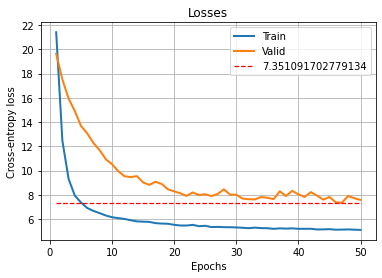

In [ ]:
plot_losses()

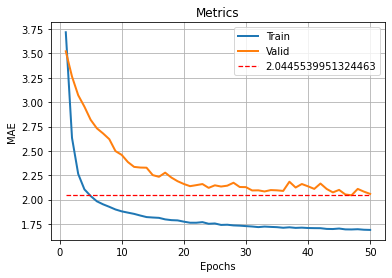

In [ ]:
plot_metrics()

In [ ]:
model = MatrixFactorizationModel(
    40, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.02)

In [ ]:
model = MatrixFactorizationModel(
    60, len(user_lookup), len(movie_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.02)

# New experiments

In [ ]:
model = MatrixFactorizationModel(
    60, len(user_lookup), len(book_lookup), ratings_range=[1, 10]
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.03)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 60
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')

all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 60


 33%|███▎      | 1/3 [00:00<00:00,  4.28it/s]

tensor(3.8750)


100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


tensor(7.7567)
tensor(11.6784)

Training loss: 23.527
Validation loss: 22.991
Training MAE: 3.9420785903930664
Validation MAE: 3.8927905559539795

 Epoch2 / 60


 33%|███▎      | 1/3 [00:00<00:00,  4.14it/s]

tensor(3.6293)


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


tensor(7.5004)
tensor(11.2580)

Training loss: 15.757
Validation loss: 21.699
Training MAE: 3.014084815979004
Validation MAE: 3.752668619155884

 Epoch3 / 60


100%|██████████| 3/3 [00:00<00:00,  9.70it/s]


tensor(3.4976)
tensor(7.1413)
tensor(10.6908)

Training loss: 12.423
Validation loss: 20.187
Training MAE: 2.630192995071411
Validation MAE: 3.563612937927246

 Epoch4 / 60


100%|██████████| 3/3 [00:00<00:00,  9.97it/s]

tensor(3.5105)
tensor(6.9580)
tensor(10.4794)



Training loss: 10.617
Validation loss: 19.339
Training MAE: 2.4250223636627197
Validation MAE: 3.4931414127349854

 Epoch5 / 60


100%|██████████| 3/3 [00:00<00:00, 10.02it/s]


tensor(3.3084)
tensor(6.6423)
tensor(10.0796)

Training loss: 9.592
Validation loss: 18.120
Training MAE: 2.311530828475952
Validation MAE: 3.3598830699920654

 Epoch6 / 60


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


tensor(3.1494)
tensor(6.3400)
tensor(9.6923)

Training loss: 8.736
Validation loss: 17.006
Training MAE: 2.2121357917785645
Validation MAE: 3.230753183364868

 Epoch7 / 60


100%|██████████| 3/3 [00:00<00:00, 10.30it/s]

tensor(3.1813)
tensor(6.3737)
tensor(9.3981)



Training loss: 8.206
Validation loss: 16.381
Training MAE: 2.1513795852661133
Validation MAE: 3.1327121257781982

 Epoch8 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  7.72it/s]

tensor(3.0960)
tensor(6.1774)


100%|██████████| 3/3 [00:00<00:00,  8.47it/s]


tensor(8.9704)

Training loss: 7.855
Validation loss: 15.112
Training MAE: 2.1096179485321045
Validation MAE: 2.990128517150879

 Epoch9 / 60


100%|██████████| 3/3 [00:00<00:00, 10.13it/s]


tensor(2.8986)
tensor(5.9614)
tensor(8.9349)

Training loss: 7.610
Validation loss: 14.877
Training MAE: 2.0799076557159424
Validation MAE: 2.97831130027771

 Epoch10 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  7.42it/s]

tensor(3.0479)
tensor(5.8314)


100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


tensor(8.6931)

Training loss: 7.396
Validation loss: 14.212
Training MAE: 2.0525858402252197
Validation MAE: 2.8977136611938477

 Epoch11 / 60


100%|██████████| 3/3 [00:00<00:00,  9.70it/s]

tensor(2.8633)
tensor(5.7375)
tensor(8.6155)



Training loss: 7.238
Validation loss: 13.936
Training MAE: 2.0332658290863037
Validation MAE: 2.871821641921997

 Epoch12 / 60


100%|██████████| 3/3 [00:00<00:00, 10.32it/s]


tensor(2.8174)
tensor(5.5170)
tensor(8.3407)

Training loss: 7.123
Validation loss: 13.207
Training MAE: 2.0165302753448486
Validation MAE: 2.780226945877075

 Epoch13 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  7.52it/s]

tensor(2.5870)
tensor(5.3432)


100%|██████████| 3/3 [00:00<00:00,  9.18it/s]


tensor(8.1484)

Training loss: 6.986
Validation loss: 12.612
Training MAE: 1.9981807470321655
Validation MAE: 2.7161319255828857

 Epoch14 / 60


100%|██████████| 3/3 [00:00<00:00, 10.37it/s]


tensor(2.6750)
tensor(5.3376)
tensor(7.7483)

Training loss: 6.877
Validation loss: 11.617
Training MAE: 1.98112154006958
Validation MAE: 2.582768678665161

 Epoch15 / 60


100%|██████████| 3/3 [00:00<00:00,  9.76it/s]


tensor(2.6771)
tensor(5.2611)
tensor(7.8398)

Training loss: 6.758
Validation loss: 11.861
Training MAE: 1.9644752740859985
Validation MAE: 2.613276243209839

 Epoch16 / 60


100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


tensor(2.5930)
tensor(5.2333)
tensor(8.0541)

Training loss: 6.704
Validation loss: 12.251
Training MAE: 1.9556795358657837
Validation MAE: 2.6846981048583984

 Epoch17 / 60


100%|██████████| 3/3 [00:00<00:00,  9.97it/s]


tensor(2.5607)
tensor(5.1848)
tensor(7.8660)

Training loss: 6.604
Validation loss: 11.737
Training MAE: 1.9387365579605103
Validation MAE: 2.6220037937164307

 Epoch18 / 60


100%|██████████| 3/3 [00:00<00:00,  9.78it/s]

tensor(2.5205)
tensor(5.0016)
tensor(7.6778)



Training loss: 6.520
Validation loss: 11.325
Training MAE: 1.9272780418395996
Validation MAE: 2.559276580810547

 Epoch19 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  5.64it/s]

tensor(2.5183)
tensor(4.9926)


100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


tensor(7.5123)

Training loss: 6.432
Validation loss: 10.826
Training MAE: 1.913467526435852
Validation MAE: 2.5040924549102783

 Epoch20 / 60


100%|██████████| 3/3 [00:00<00:00,  9.64it/s]

tensor(2.3777)
tensor(4.8904)
tensor(7.4658)



Training loss: 6.379
Validation loss: 10.604
Training MAE: 1.9030706882476807
Validation MAE: 2.4886085987091064

 Epoch21 / 60


100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

tensor(2.4943)
tensor(4.8518)
tensor(7.4683)



Training loss: 6.375
Validation loss: 10.582
Training MAE: 1.9006435871124268
Validation MAE: 2.489438056945801

 Epoch22 / 60


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

tensor(2.3393)
tensor(4.8029)
tensor(7.2096)



Training loss: 6.324
Validation loss: 9.958
Training MAE: 1.8945329189300537
Validation MAE: 2.403183698654175

 Epoch23 / 60


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


tensor(2.3826)
tensor(4.8689)
tensor(7.1284)

Training loss: 6.266
Validation loss: 9.745
Training MAE: 1.8844670057296753
Validation MAE: 2.376142740249634

 Epoch24 / 60


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


tensor(2.2923)
tensor(4.7241)
tensor(7.1182)

Training loss: 6.177
Validation loss: 9.863
Training MAE: 1.8718829154968262
Validation MAE: 2.372724771499634

 Epoch25 / 60


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

tensor(2.3725)
tensor(4.6507)
tensor(6.9287)



Training loss: 6.186
Validation loss: 9.308
Training MAE: 1.8727396726608276
Validation MAE: 2.3095552921295166

 Epoch26 / 60


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


tensor(2.3570)
tensor(4.6206)
tensor(6.9683)

Training loss: 6.107
Validation loss: 9.434
Training MAE: 1.8604023456573486
Validation MAE: 2.322775363922119

 Epoch27 / 60


100%|██████████| 3/3 [00:00<00:00,  9.62it/s]


tensor(2.3352)
tensor(4.6938)
tensor(7.0301)

Training loss: 6.070
Validation loss: 9.407
Training MAE: 1.8551748991012573
Validation MAE: 2.3433609008789062

 Epoch28 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  7.49it/s]

tensor(2.2981)
tensor(4.6477)


100%|██████████| 3/3 [00:00<00:00,  8.55it/s]


tensor(6.8778)

Training loss: 6.054
Validation loss: 9.058
Training MAE: 1.851791501045227
Validation MAE: 2.2926018238067627

 Epoch29 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  8.46it/s]

tensor(2.2552)
tensor(4.6254)


100%|██████████| 3/3 [00:00<00:00,  9.07it/s]


tensor(6.9652)

Training loss: 6.016
Validation loss: 9.294
Training MAE: 1.8461824655532837
Validation MAE: 2.3217275142669678

 Epoch30 / 60


100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


tensor(2.1972)
tensor(4.5741)
tensor(6.9218)

Training loss: 5.982
Validation loss: 9.344
Training MAE: 1.8394650220870972
Validation MAE: 2.307278871536255

 Epoch31 / 60


100%|██████████| 3/3 [00:00<00:00, 10.55it/s]


tensor(2.3983)
tensor(4.6021)
tensor(6.9659)

Training loss: 5.965
Validation loss: 9.235
Training MAE: 1.834900975227356
Validation MAE: 2.321963310241699

 Epoch32 / 60


100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


tensor(2.4102)
tensor(4.6489)
tensor(6.8771)

Training loss: 5.943
Validation loss: 9.140
Training MAE: 1.8317036628723145
Validation MAE: 2.292362928390503

 Epoch33 / 60


100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


tensor(2.2933)
tensor(4.7254)
tensor(6.7935)

Training loss: 5.894
Validation loss: 8.903
Training MAE: 1.8237625360488892
Validation MAE: 2.264493942260742

 Epoch34 / 60


100%|██████████| 3/3 [00:00<00:00,  9.76it/s]


tensor(2.2543)
tensor(4.5846)
tensor(6.8605)

Training loss: 5.904
Validation loss: 9.055
Training MAE: 1.8247724771499634
Validation MAE: 2.2868425846099854

 Epoch35 / 60


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


tensor(2.1654)
tensor(4.4560)
tensor(6.8882)

Training loss: 5.852
Validation loss: 8.991
Training MAE: 1.8164937496185303
Validation MAE: 2.2960612773895264

 Epoch36 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  7.59it/s]

tensor(2.1749)
tensor(4.5784)


100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


tensor(6.8676)

Training loss: 5.818
Validation loss: 9.201
Training MAE: 1.8103569746017456
Validation MAE: 2.28918719291687

 Epoch37 / 60


100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


tensor(2.2347)
tensor(4.5605)
tensor(6.7841)

Training loss: 5.813
Validation loss: 8.965
Training MAE: 1.8088390827178955
Validation MAE: 2.2613580226898193

 Epoch38 / 60


100%|██████████| 3/3 [00:00<00:00, 10.02it/s]

tensor(2.3126)
tensor(4.5348)
tensor(6.7388)



Training loss: 5.777
Validation loss: 8.705
Training MAE: 1.8044934272766113
Validation MAE: 2.2462821006774902

 Epoch39 / 60


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


tensor(2.3793)
tensor(4.5598)
tensor(6.6232)

Training loss: 5.729
Validation loss: 8.588
Training MAE: 1.7981407642364502
Validation MAE: 2.207735776901245

 Epoch40 / 60


100%|██████████| 3/3 [00:00<00:00,  9.36it/s]


tensor(2.1689)
tensor(4.4494)
tensor(6.6823)

Training loss: 5.696
Validation loss: 8.732
Training MAE: 1.7929054498672485
Validation MAE: 2.2274324893951416

 Epoch41 / 60


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

tensor(2.2393)
tensor(4.4177)
tensor(6.4857)



Training loss: 5.722
Validation loss: 8.221
Training MAE: 1.7920058965682983
Validation MAE: 2.161898612976074

 Epoch42 / 60


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

tensor(2.1637)
tensor(4.3144)
tensor(6.5339)



Training loss: 5.709
Validation loss: 8.187
Training MAE: 1.790318250656128
Validation MAE: 2.1779699325561523

 Epoch43 / 60


100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


tensor(2.1356)
tensor(4.3103)
tensor(6.4639)

Training loss: 5.681
Validation loss: 7.961
Training MAE: 1.7859927415847778
Validation MAE: 2.1546294689178467

 Epoch44 / 60


100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


tensor(2.1649)
tensor(4.3492)
tensor(6.4832)

Training loss: 5.691
Validation loss: 8.117
Training MAE: 1.7856924533843994
Validation MAE: 2.1610519886016846

 Epoch45 / 60


100%|██████████| 3/3 [00:00<00:00,  9.64it/s]


tensor(2.0864)
tensor(4.0560)
tensor(6.4128)

Training loss: 5.711
Validation loss: 8.108
Training MAE: 1.7890126705169678
Validation MAE: 2.1375892162323

 Epoch46 / 60


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

tensor(2.1335)
tensor(4.1407)
tensor(6.2247)



Training loss: 5.696
Validation loss: 7.477
Training MAE: 1.7854782342910767
Validation MAE: 2.074909210205078

 Epoch47 / 60


100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


tensor(2.1552)
tensor(4.2582)
tensor(6.3754)

Training loss: 5.666
Validation loss: 7.914
Training MAE: 1.7816718816757202
Validation MAE: 2.1251277923583984

 Epoch48 / 60


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


tensor(2.1273)
tensor(4.2798)
tensor(6.4764)

Training loss: 5.621
Validation loss: 8.038
Training MAE: 1.7743788957595825
Validation MAE: 2.158813714981079

 Epoch49 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  7.52it/s]

tensor(2.1434)
tensor(4.3529)


100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


tensor(6.4042)

Training loss: 5.624
Validation loss: 7.950
Training MAE: 1.7743618488311768
Validation MAE: 2.1347274780273438

 Epoch50 / 60


100%|██████████| 3/3 [00:00<00:00,  9.86it/s]


tensor(2.1990)
tensor(4.2995)
tensor(6.3926)

Training loss: 5.614
Validation loss: 7.992
Training MAE: 1.7721492052078247
Validation MAE: 2.130872964859009

 Epoch51 / 60


100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


tensor(2.0800)
tensor(4.3072)
tensor(6.3862)

Training loss: 5.550
Validation loss: 7.858
Training MAE: 1.7630410194396973
Validation MAE: 2.1287448406219482

 Epoch52 / 60


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


tensor(2.1830)
tensor(4.3556)
tensor(6.3895)

Training loss: 5.569
Validation loss: 7.721
Training MAE: 1.7630666494369507
Validation MAE: 2.129817008972168

 Epoch53 / 60


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]


tensor(2.1385)
tensor(4.2316)
tensor(6.2268)

Training loss: 5.542
Validation loss: 7.588
Training MAE: 1.7569974660873413
Validation MAE: 2.0755863189697266

 Epoch54 / 60


100%|██████████| 3/3 [00:00<00:00,  9.96it/s]


tensor(2.1017)
tensor(4.3219)
tensor(6.2816)

Training loss: 5.479
Validation loss: 7.727
Training MAE: 1.7488175630569458
Validation MAE: 2.093872308731079

 Epoch55 / 60


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


tensor(2.1965)
tensor(4.2443)
tensor(6.2080)

Training loss: 5.484
Validation loss: 7.618
Training MAE: 1.7512210607528687
Validation MAE: 2.0693490505218506

 Epoch56 / 60


100%|██████████| 3/3 [00:00<00:00, 10.22it/s]


tensor(2.0326)
tensor(4.1300)
tensor(6.4022)

Training loss: 5.441
Validation loss: 8.005
Training MAE: 1.7417657375335693
Validation MAE: 2.134078025817871

 Epoch57 / 60


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


tensor(2.1886)
tensor(4.3439)
tensor(6.4040)

Training loss: 5.463
Validation loss: 7.899
Training MAE: 1.7456088066101074
Validation MAE: 2.134653329849243

 Epoch58 / 60


100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


tensor(2.1749)
tensor(4.3278)
tensor(6.4990)

Training loss: 5.422
Validation loss: 8.190
Training MAE: 1.7382985353469849
Validation MAE: 2.166327714920044

 Epoch59 / 60


100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


tensor(2.1423)
tensor(4.3271)
tensor(6.2584)

Training loss: 5.409
Validation loss: 7.684
Training MAE: 1.7343724966049194
Validation MAE: 2.0861363410949707

 Epoch60 / 60


 67%|██████▋   | 2/3 [00:00<00:00,  7.86it/s]

tensor(2.0556)
tensor(4.2475)
tensor(6.3183)


100%|██████████| 3/3 [00:00<00:00,  9.25it/s]


Training loss: 5.394
Validation loss: 7.851
Training MAE: 1.731674313545227
Validation MAE: 2.106102705001831


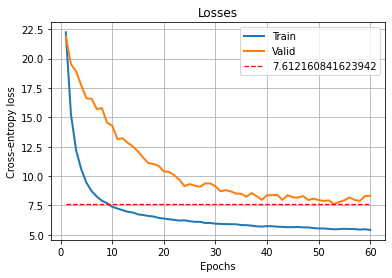

In [ ]:
plot_losses()

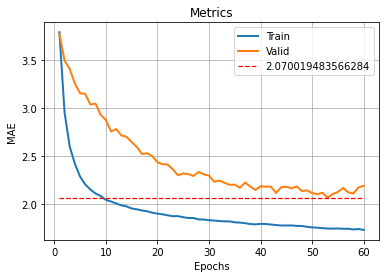

In [ ]:
plot_metrics()

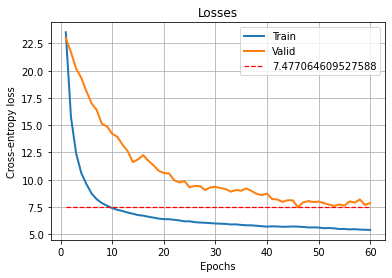

In [ ]:
plot_losses()

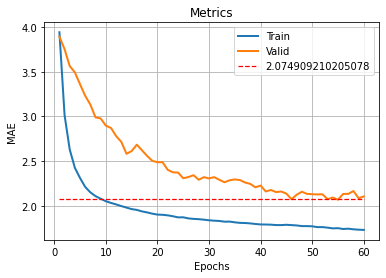

In [ ]:
plot_metrics()

# Average Precision
- Adding new metric for evaluating

In [ ]:
from random import randint

In [ ]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
def plot_mapk():
  # make data
  x = np.arange(5, 100, 1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, mapk_metrics, linewidth=2.0, label="Test")

  plt.grid()
  plt.title("AP@K Metric")
  plt.xlabel("Param k")
  plt.ylabel("Average Precision")
  ax.legend()
  plt.show()

In [ ]:
def generate_test_input(num_users=1000):
    result = []
    active_users = []
    all_users = list(user_lookup.keys())
    sorted_ratings_df = ratings_df.sort_values(by='time').reset_index()
    index = sorted_ratings_df.index
    for i in range(num_users):
        while True:
            rand = randint(0, len(user_lookup)-1)
            if rand not in active_users:
                active_users.append(rand)
                break
        user = all_users[rand]
        user_rows = index[sorted_ratings_df.user_id==user]
        row = randint(user_rows[0], user_rows[-1])
        book_id = book_lookup[sorted_ratings_df.iloc[row].Book_title]
        target_rating = sorted_ratings_df.iloc[row].rating.item()
        result.append((torch.tensor([rand+1]).to(device), torch.tensor([book_id]).to(device), target_rating))
    return result

In [ ]:
test_input = generate_test_input(1000)
test_input[:5]

[(tensor([452], device='cuda:0'), tensor([3654], device='cuda:0'), 9.0),
 (tensor([462], device='cuda:0'), tensor([773], device='cuda:0'), 10.0),
 (tensor([1270], device='cuda:0'), tensor([10122], device='cuda:0'), 8.0),
 (tensor([1232], device='cuda:0'), tensor([4956], device='cuda:0'), 3.0),
 (tensor([355], device='cuda:0'), tensor([36], device='cuda:0'), 9.0)]

In [ ]:
relevant = []
pred_book_ids = []
pred_ratings = []
for user_id, book_id, rating in test_input:
  if rating > 8:
    relevant.append(book_id[0].detach().cpu())
  pred = model((user_id, book_id))
  # print(user_id, book_id)
  # print(pred[0])
  if pred[0] > 8:
    pred_book_ids.append(book_id[0].detach().cpu())    
    pred_ratings.append(pred[0].detach().cpu())
  sorted_ids = np.argsort(pred_ratings)[::-1]
  pred_books = [pred_book_ids[i] for i in sorted_ids]
mapk_metrics = []
print(len(relevant), len(pred_books))
for i in range(5, 100, 1):
  prec = mapk([relevant], [pred_books], i)
  mapk_metrics.append(prec)

378 843


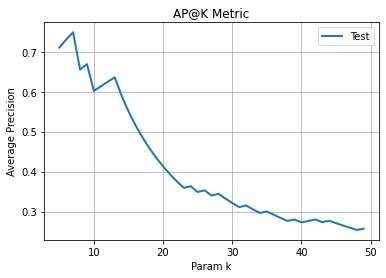

In [ ]:
plot_mapk()

In [ ]:
def plot_mapk():
  # make data
  x = np.arange(3, 20, 1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, mapk_metrics, linewidth=2.0, label="Test")

  plt.grid()
  plt.title("AP@K Metric")
  plt.xlabel("Param k")
  plt.ylabel("Average Precision")
  ax.legend()
  plt.show()

In [ ]:
mapk_metrics = []
for i in range(3, 20, 1):
  prec = mapk([relevant], [pred_books], i)
  mapk_metrics.append(prec)

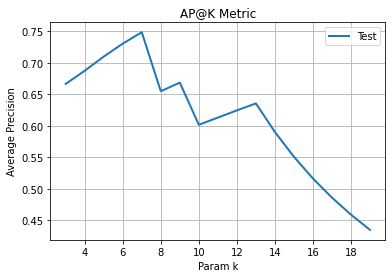

In [ ]:
plot_mapk()